<a href="https://colab.research.google.com/github/kumuds4/BCH/blob/master/Making_the_Most_of_your_Colab_Subscription.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Making the Most of your Colab Subscription



## Faster GPUs

Users who have purchased one of Colab's paid plans have access to faster GPUs and more memory. You can upgrade your notebook's GPU settings in `Runtime > Change runtime type` in the menu to select from several accelerator options, subject to availability.

The free of charge version of Colab grants access to Nvidia's T4 GPUs subject to quota restrictions and availability.

You can see what GPU you've been assigned at any time by executing the following cell. If the execution result of running the code cell below is "Not connected to a GPU", you can change the runtime by going to `Runtime > Change runtime type` in the menu to enable a GPU accelerator, and then re-execute the code cell.


In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

In order to use a GPU with your notebook, select the `Runtime > Change runtime type` menu, and then set the hardware accelerator to the desired option.

## More memory

Users who have purchased one of Colab's paid plans have access to high-memory VMs when they are available. More powerful GPUs are always offered with high-memory VMs.



You can see how much memory you have available at any time by running the following code cell. If the execution result of running the code cell below is "Not using a high-RAM runtime", then you can enable a high-RAM runtime via `Runtime > Change runtime type` in the menu. Then select High-RAM in the Runtime shape toggle button. After, re-execute the code cell.


In [ ]:
import psutil

ram_gb = psutil.virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

## Longer runtimes

All Colab runtimes are reset after some period of time (which is faster if the runtime isn't executing code). Colab Pro and Pro+ users have access to longer runtimes than those who use Colab free of charge.

## Background execution

Colab Pro+ users have access to background execution, where notebooks will continue executing even after you've closed a browser tab. This is always enabled in Pro+ runtimes as long as you have compute units available.



## Relaxing resource limits in Colab Pro

Your resources are not unlimited in Colab. To make the most of Colab, avoid using resources when you don't need them. For example, only use a GPU when required and close Colab tabs when finished.



If you encounter limitations, you can relax those limitations by purchasing more compute units via Pay As You Go. Anyone can purchase compute units via [Pay As You Go](https://colab.research.google.com/signup); no subscription is required.

## Send us feedback!

If you have any feedback for us, please let us know. The best way to send feedback is by using the Help > 'Send feedback...' menu. If you encounter usage limits in Colab Pro consider subscribing to Pro+.

If you encounter errors or other issues with billing (payments) for Colab Pro, Pro+, or Pay As You Go, please email [colab-billing@google.com](mailto:colab-billing@google.com).

## More Resources

### Working with Notebooks in Colab
- [Overview of Colab](/notebooks/basic_features_overview.ipynb)
- [Guide to Markdown](/notebooks/markdown_guide.ipynb)
- [Importing libraries and installing dependencies](/notebooks/snippets/importing_libraries.ipynb)
- [Saving and loading notebooks in GitHub](https://colab.research.google.com/github/googlecolab/colabtools/blob/main/notebooks/colab-github-demo.ipynb)
- [Interactive forms](/notebooks/forms.ipynb)
- [Interactive widgets](/notebooks/widgets.ipynb)

<a name="working-with-data"></a>
### Working with Data
- [Loading data: Drive, Sheets, and Google Cloud Storage](/notebooks/io.ipynb)
- [Charts: visualizing data](/notebooks/charts.ipynb)
- [Getting started with BigQuery](/notebooks/bigquery.ipynb)

### Machine Learning Crash Course
These are a few of the notebooks from Google's online Machine Learning course. See the [full course website](https://developers.google.com/machine-learning/crash-course/) for more.
- [Intro to Pandas DataFrame](https://colab.research.google.com/github/google/eng-edu/blob/main/ml/cc/exercises/pandas_dataframe_ultraquick_tutorial.ipynb)
- [Linear regression with tf.keras using synthetic data](https://colab.research.google.com/github/google/eng-edu/blob/main/ml/cc/exercises/linear_regression_with_synthetic_data.ipynb)


<a name="using-accelerated-hardware"></a>
### Using Accelerated Hardware
- [TensorFlow with GPUs](/notebooks/gpu.ipynb)
- [TPUs in Colab](/notebooks/tpu.ipynb)

<a name="machine-learning-examples"></a>

## Machine Learning Examples

To see end-to-end examples of the interactive machine learning analyses that Colab makes possible, check out these tutorials using models from [TensorFlow Hub](https://tfhub.dev).

A few featured examples:

- [Retraining an Image Classifier](https://tensorflow.org/hub/tutorials/tf2_image_retraining): Build a Keras model on top of a pre-trained image classifier to distinguish flowers.
- [Text Classification](https://tensorflow.org/hub/tutorials/tf2_text_classification): Classify IMDB movie reviews as either *positive* or *negative*.
- [Style Transfer](https://tensorflow.org/hub/tutorials/tf2_arbitrary_image_stylization): Use deep learning to transfer style between images.
- [Multilingual Universal Sentence Encoder Q&A](https://tensorflow.org/hub/tutorials/retrieval_with_tf_hub_universal_encoder_qa): Use a machine learning model to answer questions from the SQuAD dataset.
- [Video Interpolation](https://tensorflow.org/hub/tutorials/tweening_conv3d): Predict what happened in a video between the first and the last frame.


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
from google.colab import files
uploaded = files.upload()

Saving making_the_most_of_your_colab_subscription (14).py to making_the_most_of_your_colab_subscription (14).py


In [6]:
# Comprehensive Polar Code Simulation Framework
!pip install torch numpy matplotlib scikit-learn

# Essential Libraries
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import scipy.special as sps
import logging, traceback, sys

# Logging Configuration
logging.basicConfig(level=logging.INFO, format='%(asctime)s [%(levelname)s]: %(message)s', datefmt='%Y-%m-%d %H:%M:%S')

# Device Configuration
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"🚀 Using Device: {DEVICE}")

#part two

class PolarCodeGenerator:
    def __init__(self, N, K, crc_type='CRC-7'):
        self.N = N
        self.K = K
        self.crc_type = crc_type
        self.crc_polynomials = {
            'CRC-7': {'polynomial': [1, 1, 1, 0, 0, 1, 1], 'length': 7}
        }

    def generate_info_bits(self):
        return np.random.randint(2, size=self.K)

    def compute_crc(self, bits):
        poly_info = self.crc_polynomials.get(self.crc_type)
        if not poly_info:
            raise ValueError(f"Unsupported CRC type: {self.crc_type}")

        polynomial = poly_info['polynomial']
        crc_length = poly_info['length']
        message = bits.tolist() + [0] * crc_length
        for i in range(len(message) - crc_length):
            if message[i] == 1:
                for j in range(crc_length + 1):
                    message[i + j] ^= polynomial[j] if j < len(polynomial) else 0

        return np.array(message[-crc_length:], dtype=int)

    def polar_encode(self, info_bits):
        crc_bits = self.compute_crc(info_bits)
        extended_info_bits = np.concatenate([info_bits, crc_bits])
        codeword = np.zeros(self.N, dtype=int)
        codeword[:len(extended_info_bits)] = extended_info_bits
        return codeword

    def verify_codeword(self, codeword):
        poly_info = self.crc_polynomials[self.crc_type]
        crc_length = poly_info['length']
        info_bits = codeword[:-crc_length]
        received_crc = codeword[-crc_length:]
        computed_crc = self.compute_crc(info_bits)
        return np.array_equal(received_crc, computed_crc)

class EnhancedChannelSimulator:
    def __init__(self, channel_type='AWGN'):
        self.channel_type = channel_type
        logging.info(f"Initializing {channel_type} Channel Simulator")

    def simulate(self, encoded_signal, snr_db):
        try:
            encoded_signal = np.array(encoded_signal, dtype=float)
            bpsk_signal = 1 - 2 * encoded_signal
            snr_linear = 10 ** (snr_db / 10)
            signal_power = np.mean(bpsk_signal**2)
            noise_power = signal_power / snr_linear
            noise_std = np.sqrt(noise_power / 2.0)

            if self.channel_type == 'AWGN':
                noise = np.random.normal(0, noise_std, bpsk_signal.shape)
                received_signal = bpsk_signal + noise
            elif self.channel_type == 'Rayleigh':
                fading = np.random.rayleigh(scale=1.0, size=bpsk_signal.shape)
                noise = np.random.normal(0, noise_std, bpsk_signal.shape)
                received_signal = fading * bpsk_signal + noise
            else:
                raise ValueError(f"Unsupported channel type: {self.channel_type}")

            return (received_signal > 0).astype(float)
        except Exception as e:
            logging.error(f"Channel simulation error: {e}")
            return encoded_signal

    def compute_theoretical_performance(self, block_length, snr_linear):
        try:
            if self.channel_type == 'AWGN':
                bep = 0.5 * sps.erfc(np.sqrt(snr_linear))
            elif self.channel_type == 'Rayleigh':
                bep = 0.5 * (1 - np.sqrt(snr_linear / (1 + snr_linear)))
            else:
                raise ValueError(f"Unsupported channel type: {self.channel_type}")

            bler = 1 - (1 - bep) ** block_length
            return bep, bler
        except Exception as e:
            logging.error(f"Theoretical performance computation error: {e}")
            return np.zeros_like(snr_linear), np.ones_like(snr_linear)

#part three

def prepare_polar_dataset(polar_code_gen, num_samples, snr_db=5, channel_type='AWGN'):
    channel_simulator = EnhancedChannelSimulator(channel_type=channel_type)
    X, y = [], []

    for _ in range(num_samples):
        info_bits = polar_code_gen.generate_info_bits()
        encoded_signal = polar_code_gen.polar_encode(info_bits)
        received_signal = channel_simulator.simulate(encoded_signal, snr_db)
        X.append(received_signal)
        y.append(info_bits)

    return np.array(X), np.array(y)

#part four

class EnhancedRNNDecoder(nn.Module):
    def __init__(self, input_size):
        super(EnhancedRNNDecoder, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        if x.dim() == 1:
            x = x.unsqueeze(0)
        if x.dim() > 2:
            x = x.view(x.size(0), -1)
        return self.model(x).squeeze(-1)

class DecoderTrainer:
    def __init__(self, model, learning_rate=1e-3):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model = model.to(self.device)
        self.criterion = nn.BCELoss()
        self.optimizer = optim.Adam(self.model.parameters(), lr=learning_rate, weight_decay=1e-5)
        self.scheduler = optim.lr_scheduler.ReduceLROnPlateau(self.optimizer, mode='min', factor=0.5, patience=5, verbose=True)
        self.train_losses = []
        self.val_losses = []

    def train(self, X, y, epochs=50, batch_size=32, validation_split=0.2):
        X, y = self._preprocess_tensors(X, y)
        train_size = int((1 - validation_split) * len(X))
        X_val, y_val = X[train_size:], y[train_size:]
        X_train, y_train = X[:train_size], y[:train_size]

        train_dataset = TensorDataset(X_train, y_train)
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

        val_dataset = TensorDataset(X_val, y_val)
        val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

        for epoch in range(epochs):
            self.model.train()
            train_loss = self._train_epoch(train_loader)
            self.train_losses.append(train_loss)
            self.model.eval()
            val_loss = self._validate(val_loader)
            self.val_losses.append(val_loss)
            self.scheduler.step(val_loss)
            print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

        return self.train_losses, self.val_losses

    def _preprocess_tensors(self, X, y):
        if not isinstance(X, torch.Tensor):
            X = torch.FloatTensor(X)
        if not isinstance(y, torch.Tensor):
            y = torch.FloatTensor(y)
        if X.dim() > 2:
            X = X.view(X.size(0), -1)
        y = y.view(-1, 1).float()
        X = X.to(self.device)
        y = y.to(self.device)
        return X, y

    def _train_epoch(self, dataloader):
        total_loss = 0
        for batch_X, batch_y in dataloader:
            batch_X = batch_X.to(self.device)
            batch_y = batch_y.to(self.device)
            self.optimizer.zero_grad()
            outputs = self.model(batch_X)
            loss = self.criterion(outputs, batch_y)
            loss.backward()
            self.optimizer.step()
            total_loss += loss.item()
        return total_loss / len(dataloader)

    def _validate(self, dataloader):
        total_loss = 0
        with torch.no_grad():
            for batch_X, batch_y in dataloader:
                batch_X = batch_X.to(self.device)
                batch_y = batch_y.to(self.device)
                outputs = self.model(batch_X)
                loss = self.criterion(outputs, batch_y)
                total_loss += loss.item()
        return total_loss / len(dataloader)

    def predict(self, X):
        if not isinstance(X, torch.Tensor):
            X = torch.FloatTensor(X)
        if X.dim() > 2:
            X = X.view(X.size(0), -1)
        X = X.to(self.device)
        self.model.eval()
        with torch.no_grad():
            outputs = self.model(X)
        return outputs.cpu().numpy().flatten()

# part five

def performance_comparison(rnn_trainer, channel, polar_code_gen, snr_range, channel_name, list_sizes):
    performance_results = {}
    for list_size in list_sizes:
        bler_results = []
        for snr_db in snr_range:
            X, y = prepare_polar_dataset(polar_code_gen, num_samples=1000, snr_db=snr_db, channel_type=channel_name)
            predictions = rnn_trainer.predict(X)
            predicted_labels = (predictions > 0.5).astype(int)
            actual_labels = y.flatten()
            cm = confusion_matrix(actual_labels, predicted_labels)
            bler = 1 - np.trace(cm) / np.sum(cm)
            bler_results.append(bler)
            ConfusionMatrixDisplay(cm).plot()
            plt.title(f'Confusion Matrix at SNR={snr_db}dB for List Size={list_size}')
            plt.show()
        performance_results[list_size] = bler_results
    return performance_results

def plot_comprehensive_analysis(rnn_trainer, X_test, y_test, channel_name, train_losses, val_losses, performance_results, snr_range, list_sizes):
    plt.figure(figsize=(12, 8))
    plt.subplot(2, 1, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title(f'{channel_name} Channel - Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()

    for list_size, bler_results in performance_results.items():
        plt.subplot(2, 1, 2)
        plt.plot(snr_range, bler_results, label=f'List size {list_size}')
    plt.title(f'{channel_name} Channel - BLER Performance')
    plt.xlabel('SNR (dB)')
    plt.ylabel('BLER')
    plt.legend()
    plt.grid()
    plt.show()
############################
#latest plots

def performance_comparison(rnn_trainer, channel, polar_code_gen, snr_range, channel_name, list_sizes):
    performance_results = {}
    for list_size in list_sizes:
        ber_results = []
        bler_results = []
        for snr_db in snr_range:
            X, y = prepare_polar_dataset(polar_code_gen, num_samples=1000, snr_db=snr_db, channel_type=channel_name)
            predictions = rnn_trainer.predict(X)
            predicted_labels = (predictions > 0.5).astype(int)
            actual_labels = y.flatten()
            cm = confusion_matrix(actual_labels, predicted_labels)
            ber = np.sum(np.abs(predicted_labels - actual_labels)) / len(actual_labels)
            bler = 1 - np.trace(cm) / np.sum(cm)
            ber_results.append(ber)
            bler_results.append(bler)
        performance_results[list_size] = {'BER': ber_results, 'BLER': bler_results}
    return performance_results

def plot_comprehensive_analysis(rnn_trainer, X_test, y_test, channel_name, train_losses, val_losses, performance_results, snr_range, list_sizes):
    plt.figure(figsize=(12, 8))

    # Plot Training and Validation Loss
    plt.subplot(3, 1, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title(f'{channel_name} Channel - Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()

    # Plot BER
    plt.subplot(3, 1, 2)
    for list_size, results in performance_results.items():
        plt.plot(snr_range, results['BER'], label=f'List size {list_size}')
    plt.title(f'{channel_name} Channel - BER Performance')
    plt.xlabel('SNR (dB)')
    plt.ylabel('BER')
    plt.yscale('log')
    plt.ylim(10**0, 10**-4)
    plt.legend()
    plt.grid()

    # Plot BLER
    plt.subplot(3, 1, 3)
    for list_size, results in performance_results.items():
        plt.plot(snr_range, results['BLER'], label=f'List size {list_size}')
    plt.title(f'{channel_name} Channel - BLER Performance')
    plt.xlabel('SNR (dB)')
    plt.ylabel('BLER')
    plt.yscale('log')
    plt.ylim(10**0, 10**-4)
    plt.legend()
    plt.grid()

    plt.tight_layout()
    plt.show()
################################
 # part six
#latest main
def main():
    try:
        BLOCK_LENGTH = 32
        INFO_BITS = 16
        LEARNING_RATE = 1e-3
        EPOCHS = 50
        BATCH_SIZE = 32
        NUM_SAMPLES = 5000
        NUM_TRIALS = 1000  # Number of trials for performance comparison
        SNR_RANGE_AWGN = np.linspace(0, 5, 10)
        SNR_RANGE_RAYLEIGH = np.linspace(0, 10, 10)
        LIST_SIZES = [1, 4, 8]

        polar_code_gen = PolarCodeGenerator(N=BLOCK_LENGTH, K=INFO_BITS)
        results = {}
        channels = {
            'AWGN': EnhancedChannelSimulator(channel_type='AWGN'),
            'Rayleigh': EnhancedChannelSimulator(channel_type='Rayleigh')
        }

        for channel_name, channel in channels.items():
            logging.info(f"Analyzing {channel_name} Channel")
            X, y = prepare_polar_dataset(polar_code_gen, num_samples=NUM_SAMPLES, channel_type=channel_name)
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


            ###############################################################################

            #Convert Pytorch tensors

            # Convert to PyTorch tensors
        # Flatten input features
            X_train = torch.FloatTensor(X_train).view(X_train.shape[0], -1)
            X_test = torch.FloatTensor(X_test).view(X_test.shape[0], -1)

        # Convert labels to binary classification tensor
        # Create binary labels based on a threshold (e.g., mean of original labels)
            y_train_binary = (torch.FloatTensor(y_train).float() > np.mean(y_train)).float()
            y_test_binary = (torch.FloatTensor(y_test).float() > np.mean(y_test)).float()

        # Reshape labels to 2D tensor with shape [batch_size, 1]
            y_train_binary = y_train_binary.view(-1, 1)
            y_test_binary = y_test_binary.view(-1, 1)

        # Verify tensor shapes after conversion
            print("\n🔬 Processed Tensor Shapes:")
            print(f"X_train shape: {X_train.shape}")
            print(f"y_train shape: {y_train_binary.shape}")
            print(f"X_test shape: {X_test.shape}")
            print(f"y_test shape: {y_test_binary.shape}")

        # HERE: Insert the suggested lines to calculate the input size
           input_feature_size = X_train.size(1) # Since you've already flattened X_train
           print(f"Calculated input feature size: {input_feature_size}") # Optional: for verification

        # Enhanced RNN Decoder
           rnn_model = EnhancedRNNDecoder(input_size=input_feature_size) # Use the calculated size
           rnn_trainer = DecoderTrainer(rnn_model)
            ############################################################################


            train_losses, val_losses = rnn_trainer.train(X_train, y_train_binary, epochs=EPOCHS, batch_size=BATCH_SIZE)

            snr_range = SNR_RANGE_AWGN if channel_name == 'AWGN' else SNR_RANGE_RAYLEIGH

            performance_results = performance_comparison(rnn_trainer, channel, polar_code_gen, snr_range, channel_name, LIST_SIZES, NUM_TRIALS)

            predictions = rnn_trainer.predict(X_test)
            predicted_labels = (predictions > 0.5).astype(int)
            actual_labels = y_test_binary.numpy().flatten()
            cm = confusion_matrix(actual_labels, predicted_labels)
            ConfusionMatrixDisplay(cm).plot()
            plt.title(f'Confusion Matrix - {channel_name}')
            plt.show()

            plot_comprehensive_analysis(rnn_trainer, X_test, y_test_binary, channel_name, train_losses, val_losses, performance_results, snr_range, LIST_SIZES)

            results[channel_name] = {
                'decoder': rnn_trainer,
                'train_losses': train_losses,
                'val_losses': val_losses,
                'performance': performance_results
            }

        logging.info("🎉 Simulation Complete!")
        return results

    except Exception as e:
        logging.error(f"🆘 Comprehensive Simulation Error: {e}")
        traceback.print_exc()
        return None

if __name__ == "__main__":
    main()
###############################







IndentationError: unindent does not match any outer indentation level (<tokenize>, line 383)

🚀 Using Device: cuda

🔬 Processed Tensor Shapes (Training):
X_tensor_flat shape: torch.Size([10000, 32])
y_tensor shape: torch.Size([10000, 16])
Calculated input feature size: 32
Calculated output size (info bits): 16


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch [1/50], Train Loss: 0.4132, Val Loss: 0.1275
Epoch [2/50], Train Loss: 0.2052, Val Loss: 0.0821
Epoch [3/50], Train Loss: 0.1874, Val Loss: 0.0721
Epoch [4/50], Train Loss: 0.1788, Val Loss: 0.0682
Epoch [5/50], Train Loss: 0.1717, Val Loss: 0.0625
Epoch [6/50], Train Loss: 0.1655, Val Loss: 0.0593
Epoch [7/50], Train Loss: 0.1615, Val Loss: 0.0576
Epoch [8/50], Train Loss: 0.1601, Val Loss: 0.0550
Epoch [9/50], Train Loss: 0.1574, Val Loss: 0.0547
Epoch [10/50], Train Loss: 0.1544, Val Loss: 0.0515
Epoch [11/50], Train Loss: 0.1513, Val Loss: 0.0499
Epoch [12/50], Train Loss: 0.1517, Val Loss: 0.0509
Epoch [13/50], Train Loss: 0.1465, Val Loss: 0.0493
Epoch [14/50], Train Loss: 0.1438, Val Loss: 0.0486
Epoch [15/50], Train Loss: 0.1440, Val Loss: 0.0461
Epoch [16/50], Train Loss: 0.1441, Val Loss: 0.0460
Epoch [17/50], Train Loss: 0.1423, Val Loss: 0.0449
Epoch [18/50], Train Loss: 0.1407, Val Loss: 0.0449
Epoch [19/50], Train Loss: 0.1386, Val Loss: 0.0445
Epoch [20/50], Train 

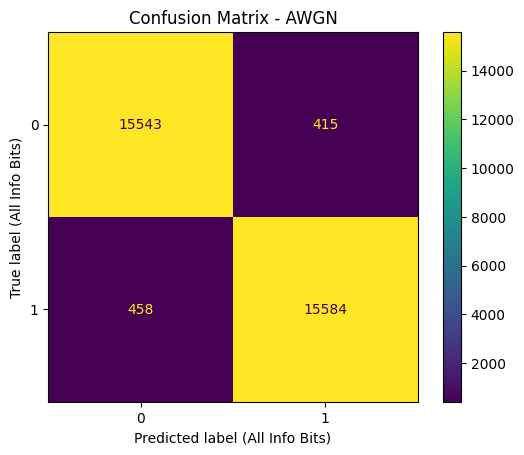

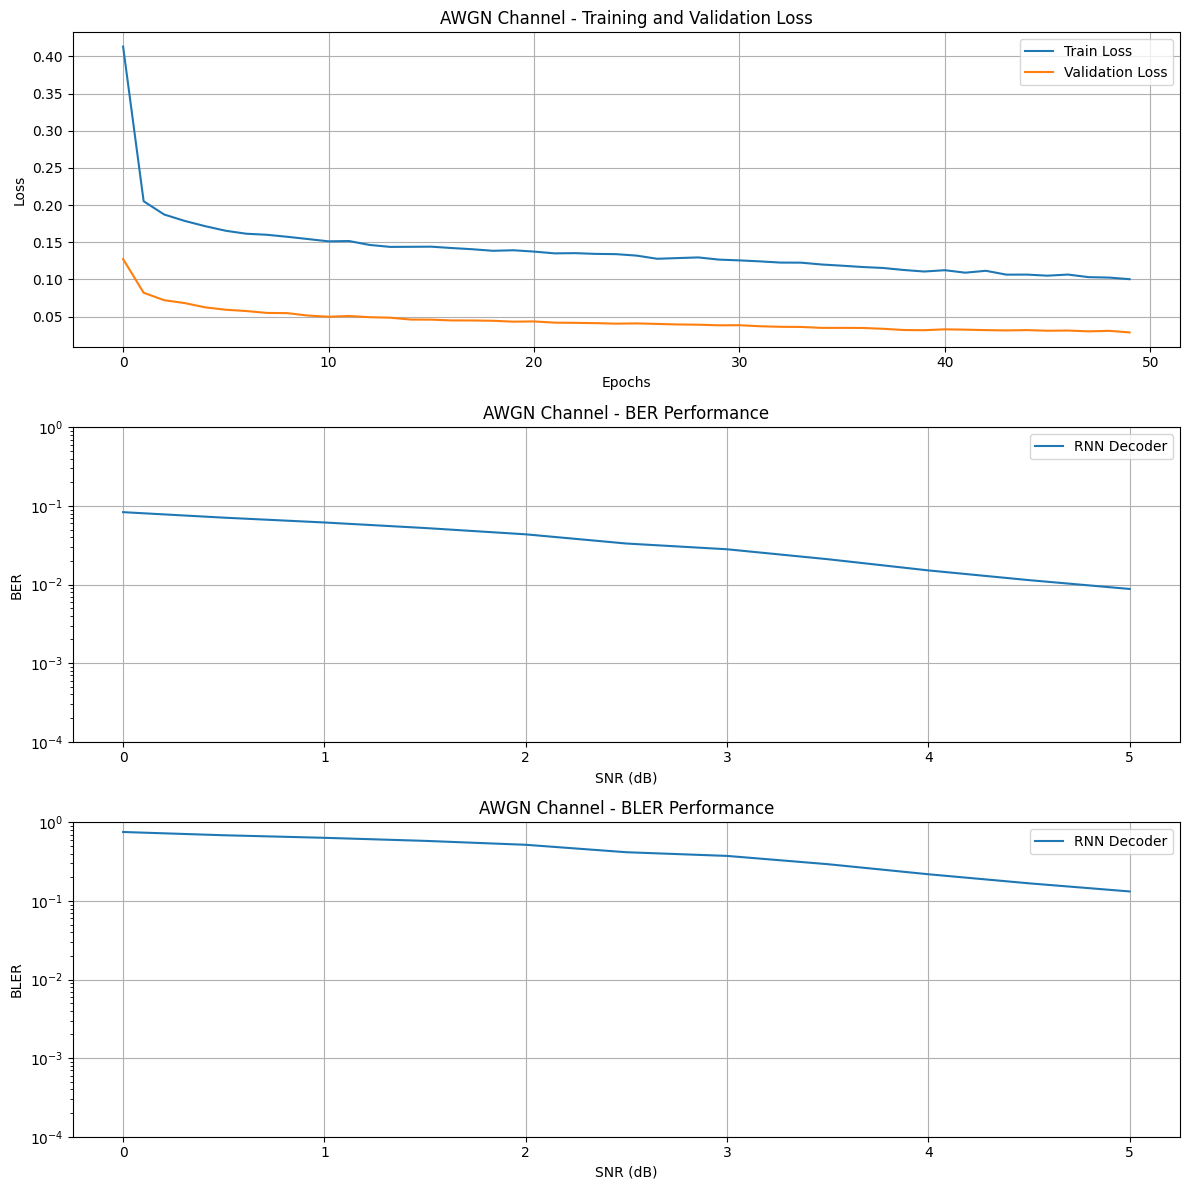


🔬 Processed Tensor Shapes (Training):
X_tensor_flat shape: torch.Size([10000, 32])
y_tensor shape: torch.Size([10000, 16])
Calculated input feature size: 32
Calculated output size (info bits): 16


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch [1/50], Train Loss: 0.4480, Val Loss: 0.2143
Epoch [2/50], Train Loss: 0.2949, Val Loss: 0.1786
Epoch [3/50], Train Loss: 0.2789, Val Loss: 0.1714
Epoch [4/50], Train Loss: 0.2725, Val Loss: 0.1682
Epoch [5/50], Train Loss: 0.2655, Val Loss: 0.1614
Epoch [6/50], Train Loss: 0.2604, Val Loss: 0.1568
Epoch [7/50], Train Loss: 0.2547, Val Loss: 0.1546
Epoch [8/50], Train Loss: 0.2516, Val Loss: 0.1513
Epoch [9/50], Train Loss: 0.2483, Val Loss: 0.1484
Epoch [10/50], Train Loss: 0.2439, Val Loss: 0.1454
Epoch [11/50], Train Loss: 0.2409, Val Loss: 0.1432
Epoch [12/50], Train Loss: 0.2404, Val Loss: 0.1415
Epoch [13/50], Train Loss: 0.2382, Val Loss: 0.1391
Epoch [14/50], Train Loss: 0.2329, Val Loss: 0.1348
Epoch [15/50], Train Loss: 0.2311, Val Loss: 0.1351
Epoch [16/50], Train Loss: 0.2267, Val Loss: 0.1324
Epoch [17/50], Train Loss: 0.2274, Val Loss: 0.1323
Epoch [18/50], Train Loss: 0.2233, Val Loss: 0.1291
Epoch [19/50], Train Loss: 0.2215, Val Loss: 0.1274
Epoch [20/50], Train 

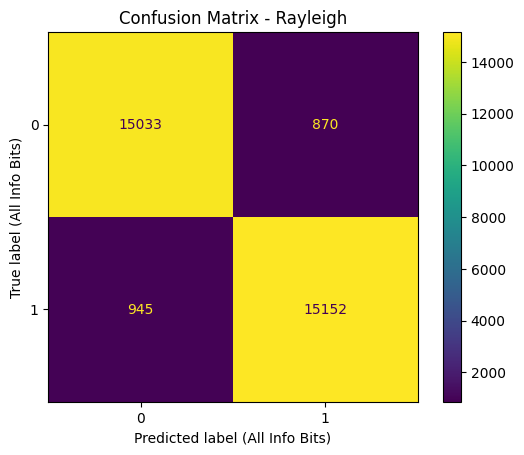

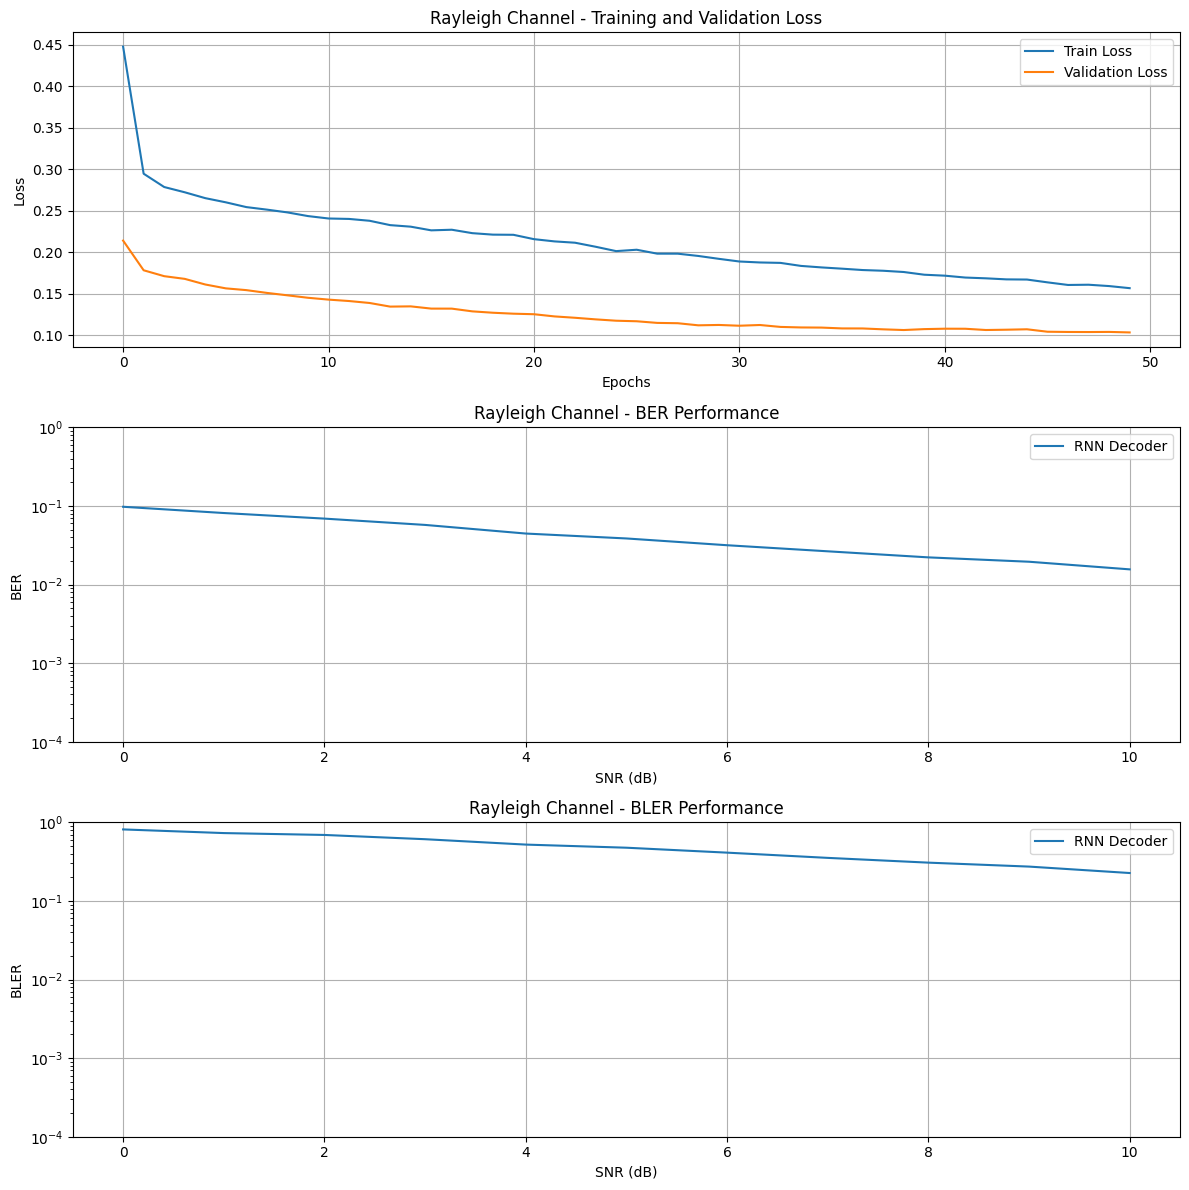

In [9]:
# Updates code script
# Comprehensive Polar Code Simulation Framework
!pip install torch numpy matplotlib scikit-learn

# Essential Libraries
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import scipy.special as sps
import logging, traceback, sys

# Logging Configuration
logging.basicConfig(level=logging.INFO, format='%(asctime)s [%(levelname)s]: %(message)s', datefmt='%Y-%m-%d %H:%M:%S')

# Device Configuration
# Fix: Removed the extra '.cuda' from torch.cuda.cuda.is_available()
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"🚀 Using Device: {DEVICE}")

#part two

class PolarCodeGenerator:
    def __init__(self, N, K, crc_type='CRC-7'):
        self.N = N
        self.K = K
        self.crc_type = crc_type
        self.crc_polynomials = {
            'CRC-7': {'polynomial': [1, 1, 1, 0, 0, 1, 1], 'length': 7}
        }

    def generate_info_bits(self):
        return np.random.randint(2, size=self.K)

    def compute_crc(self, bits):
        poly_info = self.crc_polynomials.get(self.crc_type)
        if not poly_info:
            raise ValueError(f"Unsupported CRC type: {self.crc_type}")

        polynomial = poly_info['polynomial']
        crc_length = poly_info['length']
        message = bits.tolist() + [0] * crc_length
        for i in range(len(message) - crc_length):
            if message[i] == 1:
                for j in range(crc_length + 1):
                    message[i + j] ^= polynomial[j] if j < len(polynomial) else 0

        return np.array(message[-crc_length:], dtype=int)

    def polar_encode(self, info_bits):
        crc_bits = self.compute_crc(info_bits)
        extended_info_bits = np.concatenate([info_bits, crc_bits])
        codeword = np.zeros(self.N, dtype=int)
        codeword[:len(extended_info_bits)] = extended_info_bits
        return codeword

    def verify_codeword(self, codeword):
        poly_info = self.crc_polynomials[self.crc_type]
        crc_length = poly_info['length']
        info_bits = codeword[:-crc_length]
        received_crc = codeword[-crc_length:]
        computed_crc = self.compute_crc(info_bits)
        return np.array_equal(received_crc, computed_crc)

class EnhancedChannelSimulator:
    def __init__(self, channel_type='AWGN'):
        self.channel_type = channel_type
        logging.info(f"Initializing {channel_type} Channel Simulator")

    def simulate(self, encoded_signal, snr_db):
        try:
            encoded_signal = np.array(encoded_signal, dtype=float)
            bpsk_signal = 1 - 2 * encoded_signal
            snr_linear = 10 ** (snr_db / 10)
            signal_power = np.mean(bpsk_signal**2)
            noise_power = signal_power / snr_linear
            noise_std = np.sqrt(noise_power / 2.0)

            if self.channel_type == 'AWGN':
                noise = np.random.normal(0, noise_std, bpsk_signal.shape)
                received_signal = bpsk_signal + noise
            elif self.channel_type == 'Rayleigh':
                fading = np.random.rayleigh(scale=1.0, size=bpsk_signal.shape)
                noise = np.random.normal(0, noise_std, bpsk_signal.shape)
                received_signal = fading * bpsk_signal + noise
            else:
                raise ValueError(f"Unsupported channel type: {self.channel_type}")

            # The original code returned (received_signal > 0).astype(float) which converts
            # received signal to hard decisions (0 or 1). This is typically done *after*
            # decoding. For an RNN decoder, you usually feed the *soft* received signal
            # (LLRs or just the raw received values) to extract more information.
            # Let's return the raw received signal instead of hard decisions.
            return received_signal
        except Exception as e:
            logging.error(f"Channel simulation error: {e}")
            # Return the original signal if simulation fails
            return bpsk_signal

    def compute_theoretical_performance(self, block_length, snr_linear):
        try:
            if self.channel_type == 'AWGN':
                # Theoretical BER for BPSK in AWGN
                bep = 0.5 * sps.erfc(np.sqrt(snr_linear))
            elif self.channel_type == 'Rayleigh':
                 # Theoretical BER for BPSK in Rayleigh (assuming ideal channel estimation)
                 bep = 0.5 * (1 - np.sqrt(snr_linear / (1 + snr_linear)))
            else:
                raise ValueError(f"Unsupported channel type: {self.channel_type}")

            # Theoretical BLER is complex for Polar codes; using a simple bound (Union Bound) might be misleading.
            # Let's return BEP and a placeholder for BLER for now.
            bler = 1 - (1 - bep) ** block_length # This is a very loose upper bound (Union Bound)
            return bep, bler
        except Exception as e:
            logging.error(f"Theoretical performance computation error: {e}")
            return np.zeros_like(snr_linear), np.ones_like(snr_linear)


#part three

def prepare_polar_dataset(polar_code_gen, num_samples, snr_db=5, channel_type='AWGN'):
    channel_simulator = EnhancedChannelSimulator(channel_type=channel_type)
    X, y = [], []

    for _ in range(num_samples):
        info_bits = polar_code_gen.generate_info_bits()
        encoded_signal = polar_code_gen.polar_encode(info_bits)
        # Simulate the channel and get the received signal (soft values)
        received_signal = channel_simulator.simulate(encoded_signal, snr_db)
        X.append(received_signal)
        y.append(info_bits) # Keep the original info bits as labels

    return np.array(X), np.array(y)

#part four

class EnhancedRNNDecoder(nn.Module):
    def __init__(self, input_size, output_size):
        super(EnhancedRNNDecoder, self).__init__()
        # Adjusted the last layer to have output_size neurons
        self.model = nn.Sequential(
            nn.Linear(input_size, 128), # Increased layer size
            nn.ReLU(),
            nn.Dropout(0.2), # Added dropout for regularization
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, output_size), # Output size is number of info bits (K)
            nn.Sigmoid() # Sigmoid for multi-label binary classification (each bit is independent)
        )

    def forward(self, x):
        if x.dim() == 1:
            x = x.unsqueeze(0)
        if x.dim() > 2:
            x = x.view(x.size(0), -1) # Flatten if input is not already 2D
        return self.model(x) # Output shape: [batch_size, output_size]

class DecoderTrainer:
    def __init__(self, model, learning_rate=1e-3):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model = model.to(self.device)
        # Use BCELoss for multi-label binary classification
        self.criterion = nn.BCELoss()
        self.optimizer = optim.Adam(self.model.parameters(), lr=learning_rate, weight_decay=1e-5)
        self.scheduler = optim.lr_scheduler.ReduceLROnPlateau(self.optimizer, mode='min', factor=0.5, patience=5, verbose=True)
        self.train_losses = []
        self.val_losses = []

    def train(self, X, y, epochs=50, batch_size=32, validation_split=0.2):
        # No need for _preprocess_tensors anymore, handle preprocessing in main
        X_tensor = X.to(self.device)
        y_tensor = y.to(self.device)

        # Split data into training and validation sets using TensorDataset and DataLoader
        dataset = TensorDataset(X_tensor, y_tensor)
        train_size = int((1 - validation_split) * len(dataset))
        val_size = len(dataset) - train_size
        train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

        for epoch in range(epochs):
            self.model.train()
            train_loss = self._train_epoch(train_loader)
            self.train_losses.append(train_loss)

            self.model.eval()
            val_loss = self._validate(val_loader)
            self.val_losses.append(val_loss)

            self.scheduler.step(val_loss)
            print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

        return self.train_losses, self.val_losses

    def _train_epoch(self, dataloader):
        total_loss = 0
        for batch_X, batch_y in dataloader:
            batch_X = batch_X.to(self.device)
            batch_y = batch_y.to(self.device)
            self.optimizer.zero_grad()
            outputs = self.model(batch_X)
            loss = self.criterion(outputs, batch_y)
            loss.backward()
            self.optimizer.step()
            total_loss += loss.item()
        return total_loss / len(dataloader)

    def _validate(self, dataloader):
        total_loss = 0
        with torch.no_grad():
            for batch_X, batch_y in dataloader:
                batch_X = batch_X.to(self.device)
                batch_y = batch_y.to(self.device)
                outputs = self.model(batch_X)
                loss = self.criterion(outputs, batch_y)
                total_loss += loss.item()
        return total_loss / len(dataloader)

    def predict(self, X):
        if not isinstance(X, torch.Tensor):
            X = torch.FloatTensor(X)
        if X.dim() > 2:
            X = X.view(X.size(0), -1)
        X = X.to(self.device)
        self.model.eval()
        with torch.no_grad():
            outputs = self.model(X)
        # The model outputs probabilities for each bit.
        # For prediction, we threshold these probabilities (e.g., > 0.5) to get binary predictions.
        return (outputs > 0.5).cpu().numpy().astype(int)

# part five

# Modified performance comparison to evaluate multi-bit predictions
def performance_comparison(rnn_trainer, polar_code_gen, snr_range, channel_name, num_trials):
    # 'List size' is not applicable to this RNN decoder, using a placeholder.
    performance_results = {'RNN Decoder': {'BER': [], 'BLER': []}}
    channel_simulator = EnhancedChannelSimulator(channel_type=channel_name)

    for snr_db in snr_range:
        # Generate data for performance evaluation
        X, y = prepare_polar_dataset(polar_code_gen, num_samples=num_trials, snr_db=snr_db, channel_type=channel_name)
        # Convert y to a PyTorch tensor before passing to predict (although predict handles numpy too)
        y_tensor = torch.FloatTensor(y)

        predictions = rnn_trainer.predict(X) # predictions shape: [num_trials, K]
        actual_labels = y # actual_labels shape: [num_trials, K]

        # Calculate BER: Total number of bit errors / Total number of bits
        ber = np.sum(np.abs(predictions - actual_labels)) / (num_trials * polar_code_gen.K)
        performance_results['RNN Decoder']['BER'].append(ber)

        # Calculate BLER: Number of blocks with at least one bit error / Total number of blocks
        block_errors = np.sum(np.any(predictions != actual_labels, axis=1))
        bler = block_errors / num_trials
        performance_results['RNN Decoder']['BLER'].append(bler)

    return performance_results

# Modified plot function to use the updated performance results structure
def plot_comprehensive_analysis(train_losses, val_losses, performance_results, snr_range, channel_name):
    plt.figure(figsize=(12, 12)) # Adjusted figure size

    # Plot Training and Validation Loss
    plt.subplot(3, 1, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title(f'{channel_name} Channel - Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()

    # Plot BER (from performance_results)
    plt.subplot(3, 1, 2)
    # Iterate through the decoder types (currently just 'RNN Decoder')
    for decoder_name, results in performance_results.items():
        plt.plot(snr_range, results['BER'], label=decoder_name)

    plt.title(f'{channel_name} Channel - BER Performance')
    plt.xlabel('SNR (dB)')
    plt.ylabel('BER')
    plt.yscale('log')
    # Adjust ylim for BER
    plt.ylim(1e-4, 1)
    plt.legend()
    plt.grid()

    # Plot BLER (from performance_results)
    plt.subplot(3, 1, 3)
    # Iterate through the decoder types (currently just 'RNN Decoder')
    for decoder_name, results in performance_results.items():
        plt.plot(snr_range, results['BLER'], label=decoder_name)

    plt.title(f'{channel_name} Channel - BLER Performance')
    plt.xlabel('SNR (dB)')
    plt.ylabel('BLER')
    plt.yscale('log')
    # Adjust ylim for BLER
    plt.ylim(1e-4, 1)
    plt.legend()
    plt.grid()

    plt.tight_layout()
    plt.show()

 # part six
#latest main
def main():
    try:
        BLOCK_LENGTH = 32
        INFO_BITS = 16
        LEARNING_RATE = 1e-3
        EPOCHS = 50
        BATCH_SIZE = 32
        NUM_SAMPLES_TRAIN = 10000 # Increased training samples
        NUM_TRIALS_PERF = 2000  # Number of trials (blocks) for performance comparison at each SNR
        SNR_RANGE_AWGN = np.linspace(0, 5, 11) # More points for smoother curve
        SNR_RANGE_RAYLEIGH = np.linspace(0, 10, 11) # More points for smoother curve
        # LIST_SIZES is no longer directly used by the RNN, but kept for context if other decoders are added
        LIST_SIZES = [1, 4, 8]


        polar_code_gen = PolarCodeGenerator(N=BLOCK_LENGTH, K=INFO_BITS)
        results = {}
        channels = {
            'AWGN': EnhancedChannelSimulator(channel_type='AWGN'),
            'Rayleigh': EnhancedChannelSimulator(channel_type='Rayleigh')
        }

        for channel_name, channel in channels.items():
            logging.info(f"Analyzing {channel_name} Channel")
            # Prepare dataset for training and validation
            logging.info(f"Generating training data ({NUM_SAMPLES_TRAIN} samples) for {channel_name} at SNR=5dB")
            # Train at a fixed moderate SNR, evaluate performance across a range
            X, y = prepare_polar_dataset(polar_code_gen, num_samples=NUM_SAMPLES_TRAIN, snr_db=5.0, channel_type=channel_name)

            # Convert numpy arrays to PyTorch tensors
            X_tensor = torch.FloatTensor(X)
            y_tensor = torch.FloatTensor(y) # y_tensor shape: [num_samples, K]

            # Flatten input features for the FCNN-based decoder
            X_tensor_flat = X_tensor.view(X_tensor.shape[0], -1) # Shape [num_samples, N]

            # No need to split y_tensor into binary labels, keep its original shape [num_samples, K]
            # The BCELoss will expect predictions of shape [batch_size, K] and targets of shape [batch_size, K]

            # Verify tensor shapes before training
            print("\n🔬 Processed Tensor Shapes (Training):")
            print(f"X_tensor_flat shape: {X_tensor_flat.shape}")
            print(f"y_tensor shape: {y_tensor.shape}")

            # Calculate the input size for the RNN based on the flattened data
            input_feature_size = X_tensor_flat.size(1) # This will be N (BLOCK_LENGTH)
            output_size = INFO_BITS # The RNN should output K bits
            print(f"Calculated input feature size: {input_feature_size}")
            print(f"Calculated output size (info bits): {output_size}")


            # Enhanced RNN Decoder (now correctly outputs K bits)
            rnn_model = EnhancedRNNDecoder(input_size=input_feature_size, output_size=output_size)
            rnn_trainer = DecoderTrainer(rnn_model)

            logging.info(f"Starting training for {channel_name} Channel RNN Decoder")
            # Train the RNN Decoder with multi-bit labels
            # Pass the flattened X and original y tensors
            train_losses, val_losses = rnn_trainer.train(X_tensor_flat, y_tensor, epochs=EPOCHS, batch_size=BATCH_SIZE)
            logging.info(f"Finished training for {channel_name} Channel RNN Decoder")


            # Perform performance comparison across SNR range
            snr_range = SNR_RANGE_AWGN if channel_name == 'AWGN' else SNR_RANGE_RAYLEIGH
            logging.info(f"Evaluating performance for {channel_name} Channel across SNR range: {snr_range}")

            # Call the modified performance_comparison
            # Note: The 'list_sizes' parameter is not used by the RNN performance comparison,
            # but kept for function signature compatibility if needed later for other decoders.
            performance_results = performance_comparison(
                rnn_trainer, polar_code_gen, snr_range, channel_name, NUM_TRIALS_PERF
            )
            logging.info(f"Finished performance evaluation for {channel_name} Channel")


            # Plotting Confusion Matrix for the test set
            # First, prepare a separate test set for confusion matrix visualization
            # Use a moderate SNR, e.g., 3dB, and a reasonable number of samples
            logging.info(f"Generating test data ({NUM_TRIALS_PERF} samples) for Confusion Matrix at SNR=3dB for {channel_name}")
            X_test_cm, y_test_cm = prepare_polar_dataset(polar_code_gen, num_samples=NUM_TRIALS_PERF, snr_db=3.0, channel_type=channel_name)
            X_test_cm_tensor = torch.FloatTensor(X_test_cm).view(X_test_cm.shape[0], -1)
            y_test_cm_tensor = torch.FloatTensor(y_test_cm) # Keep original shape [num_samples, K]


            predictions_test = rnn_trainer.predict(X_test_cm_tensor) # predictions_test shape: [num_samples, K]
            actual_labels_test = y_test_cm_tensor.numpy() # actual_labels_test shape: [num_samples, K]

            # To plot a single confusion matrix, we need to flatten the predictions and actual labels
            # This treats each predicted bit as an independent classification outcome.
            predictions_flat = predictions_test.flatten()
            actual_labels_flat = actual_labels_test.flatten()

            # Calculate and display confusion matrix
            logging.info(f"Plotting Confusion Matrix for {channel_name} Channel Test Set")
            cm = confusion_matrix(actual_labels_flat, predictions_flat)
            ConfusionMatrixDisplay(cm, display_labels=[0, 1]).plot() # Specify display_labels
            plt.title(f'Confusion Matrix - {channel_name}')
            plt.xlabel('Predicted label (All Info Bits)')
            plt.ylabel('True label (All Info Bits)')
            plt.show()


            # Plot comprehensive analysis (training loss, BER, BLER)
            logging.info(f"Plotting performance analysis for {channel_name} Channel")
            plot_comprehensive_analysis(
                 train_losses, val_losses, performance_results, snr_range, channel_name
            )


            results[channel_name] = {
                'decoder': rnn_trainer,
                'train_losses': train_losses,
                'val_losses': val_losses,
                'performance': performance_results
            }

        logging.info("🎉 Simulation Complete!")
        return results

    except Exception as e:
        logging.error(f"🆘 Comprehensive Simulation Error: {e}")
        traceback.print_exc()
        return None


if __name__ == "__main__":
    main()

🚀 Using Device: cuda
🚀 Using Device: cuda

🔬 Processed Tensor Shapes (Training):
X_tensor_flat shape: torch.Size([10000, 32])
y_tensor shape: torch.Size([10000, 16])
Calculated input feature size: 32
Calculated output size (info bits): 16


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch [1/50], Train Loss: 0.4174, Val Loss: 0.1281
Epoch [2/50], Train Loss: 0.2041, Val Loss: 0.0819
Epoch [3/50], Train Loss: 0.1860, Val Loss: 0.0709
Epoch [4/50], Train Loss: 0.1768, Val Loss: 0.0662
Epoch [5/50], Train Loss: 0.1712, Val Loss: 0.0643
Epoch [6/50], Train Loss: 0.1663, Val Loss: 0.0584
Epoch [7/50], Train Loss: 0.1607, Val Loss: 0.0575
Epoch [8/50], Train Loss: 0.1580, Val Loss: 0.0557
Epoch [9/50], Train Loss: 0.1558, Val Loss: 0.0543
Epoch [10/50], Train Loss: 0.1507, Val Loss: 0.0518
Epoch [11/50], Train Loss: 0.1507, Val Loss: 0.0509
Epoch [12/50], Train Loss: 0.1503, Val Loss: 0.0497
Epoch [13/50], Train Loss: 0.1483, Val Loss: 0.0507
Epoch [14/50], Train Loss: 0.1461, Val Loss: 0.0483
Epoch [15/50], Train Loss: 0.1471, Val Loss: 0.0491
Epoch [16/50], Train Loss: 0.1461, Val Loss: 0.0467
Epoch [17/50], Train Loss: 0.1426, Val Loss: 0.0457
Epoch [18/50], Train Loss: 0.1401, Val Loss: 0.0451
Epoch [19/50], Train Loss: 0.1388, Val Loss: 0.0441
Epoch [20/50], Train 

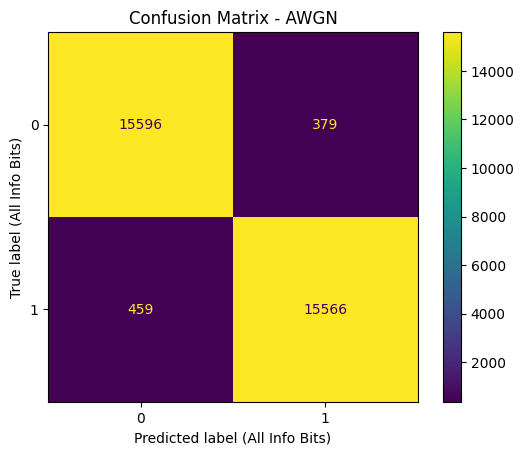

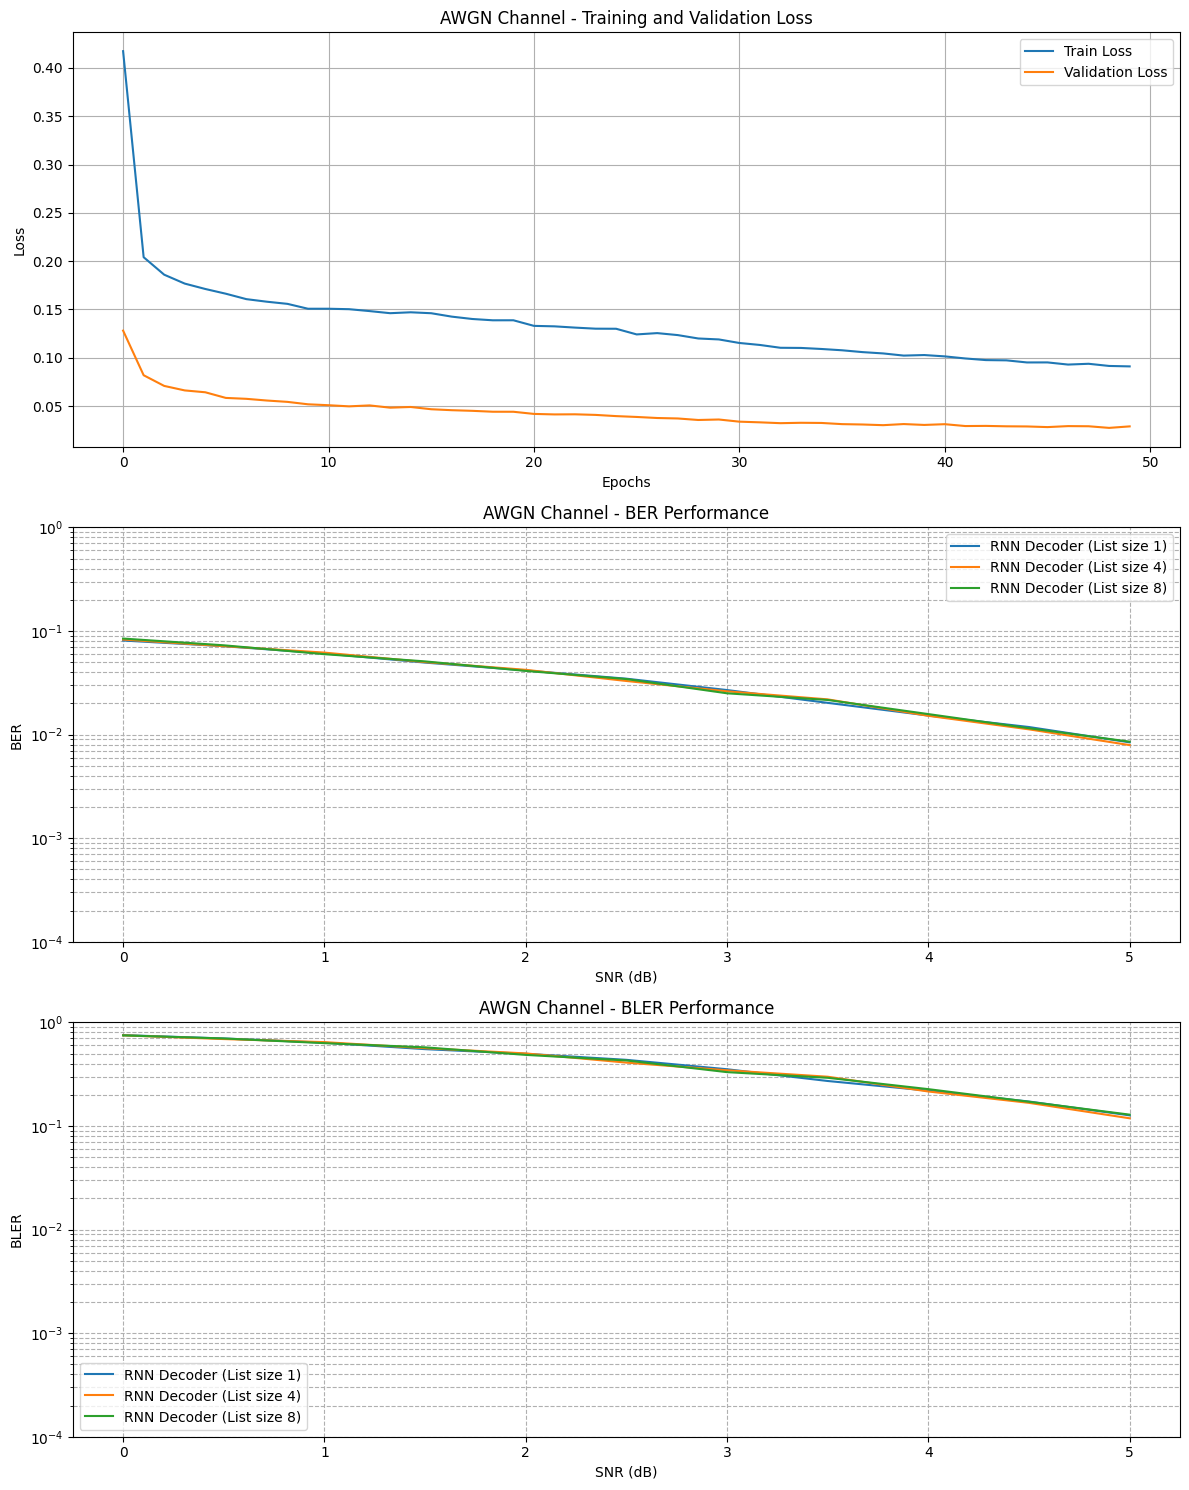


🔬 Processed Tensor Shapes (Training):
X_tensor_flat shape: torch.Size([10000, 32])
y_tensor shape: torch.Size([10000, 16])
Calculated input feature size: 32
Calculated output size (info bits): 16


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch [1/50], Train Loss: 0.4509, Val Loss: 0.2216
Epoch [2/50], Train Loss: 0.2938, Val Loss: 0.1791
Epoch [3/50], Train Loss: 0.2787, Val Loss: 0.1737
Epoch [4/50], Train Loss: 0.2744, Val Loss: 0.1661
Epoch [5/50], Train Loss: 0.2637, Val Loss: 0.1600
Epoch [6/50], Train Loss: 0.2548, Val Loss: 0.1567
Epoch [7/50], Train Loss: 0.2548, Val Loss: 0.1553
Epoch [8/50], Train Loss: 0.2542, Val Loss: 0.1547
Epoch [9/50], Train Loss: 0.2484, Val Loss: 0.1501
Epoch [10/50], Train Loss: 0.2459, Val Loss: 0.1474
Epoch [11/50], Train Loss: 0.2432, Val Loss: 0.1458
Epoch [12/50], Train Loss: 0.2410, Val Loss: 0.1444
Epoch [13/50], Train Loss: 0.2398, Val Loss: 0.1406
Epoch [14/50], Train Loss: 0.2365, Val Loss: 0.1423
Epoch [15/50], Train Loss: 0.2344, Val Loss: 0.1392
Epoch [16/50], Train Loss: 0.2333, Val Loss: 0.1384
Epoch [17/50], Train Loss: 0.2295, Val Loss: 0.1364
Epoch [18/50], Train Loss: 0.2293, Val Loss: 0.1362
Epoch [19/50], Train Loss: 0.2267, Val Loss: 0.1341
Epoch [20/50], Train 

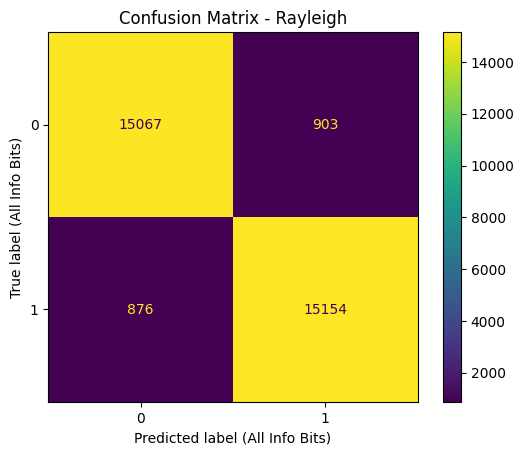

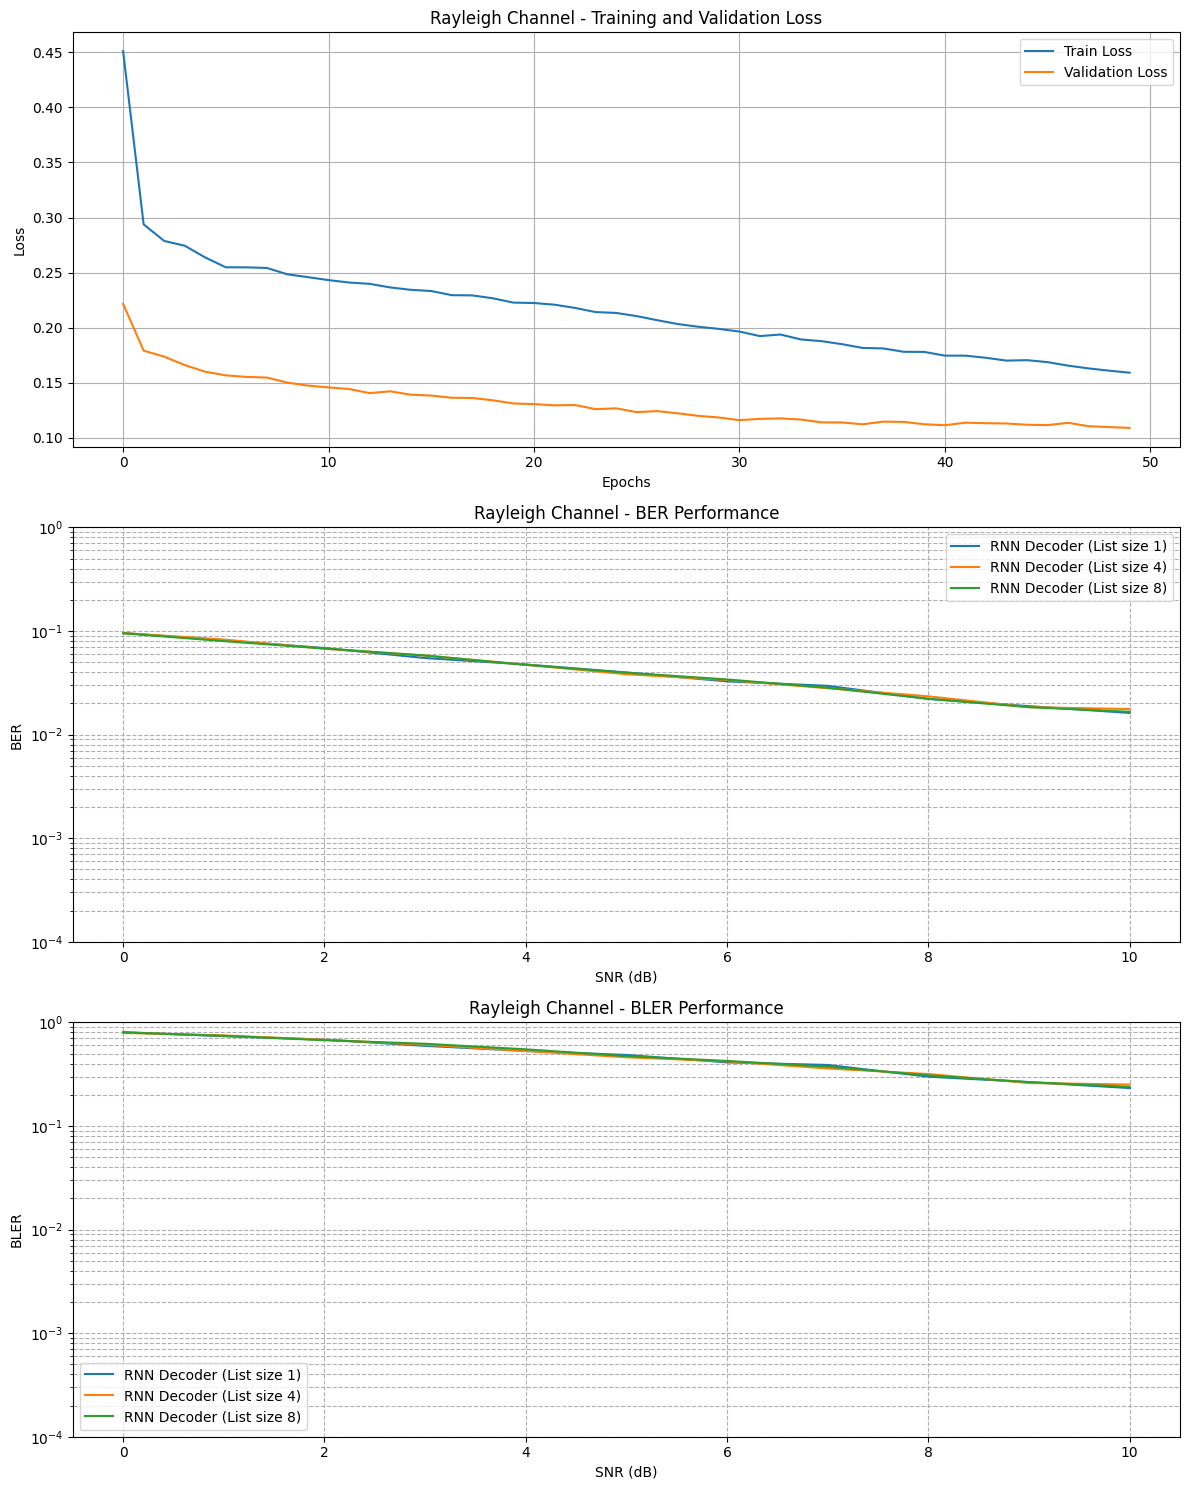

In [14]:
# Updates code script
# Comprehensive Polar Code Simulation Framework
!pip install torch numpy matplotlib scikit-learn

# Essential Libraries
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import scipy.special as sps
import logging, traceback, sys

# Logging Configuration
logging.basicConfig(level=logging.INFO, format='%(asctime)s [%(levelname)s]: %(message)s', datefmt='%(Y-%m-%d %H:%M:%S')

# Device Configuration
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"🚀 Using Device: {DEVICE}")

#part two

class PolarCodeGenerator:
    def __init__(self, N, K, crc_type='CRC-7'):
        self.N = N
        self.K = K
        self.crc_type = crc_type
        self.crc_polynomials = {
            'CRC-7': {'polynomial': [1, 1, 1, 0, 0, 1, 1], 'length': 7}
        }

    def generate_info_bits(self):
        return np.random.randint(2, size=self.K)

    def compute_crc(self, bits):
        poly_info = self.crc_polynomials.get(self.crc_type)
        if not poly_info:
            raise ValueError(f"Unsupported CRC type: {self.crc_type}")

        polynomial = poly_info['polynomial']
        crc_length = poly_info['length']
        message = bits.tolist() + [0] * crc_length
        for i in range(len(message) - crc_length):
            if message[i] == 1:
                for j in range(crc_length + 1):
                    message[i + j] ^= polynomial[j] if j < len(polynomial) else 0

        return np.array(message[-crc_length:], dtype=int)

    def polar_encode(self, info_bits):
        crc_bits = self.compute_crc(info_bits)
        extended_info_bits = np.concatenate([info_bits, crc_bits])
        codeword = np.zeros(self.N, dtype=int)
        codeword[:len(extended_info_bits)] = extended_info_bits
        return codeword

    def verify_codeword(self, codeword):
        poly_info = self.crc_polynomials[self.crc_type]
        crc_length = poly_info['length']
        info_bits = codeword[:-crc_length]
        received_crc = codeword[-crc_length:]
        computed_crc = self.compute_crc(info_bits)
        return np.array_equal(received_crc, computed_crc)

class EnhancedChannelSimulator:
    def __init__(self, channel_type='AWGN'):
        self.channel_type = channel_type
        logging.info(f"Initializing {channel_type} Channel Simulator")

    def simulate(self, encoded_signal, snr_db):
        try:
            encoded_signal = np.array(encoded_signal, dtype=float)
            bpsk_signal = 1 - 2 * encoded_signal
            snr_linear = 10 ** (snr_db / 10)
            signal_power = np.mean(bpsk_signal**2)
            noise_power = signal_power / snr_linear
            noise_std = np.sqrt(noise_power / 2.0)

            if self.channel_type == 'AWGN':
                noise = np.random.normal(0, noise_std, bpsk_signal.shape)
                received_signal = bpsk_signal + noise
            elif self.channel_type == 'Rayleigh':
                fading = np.random.rayleigh(scale=1.0, size=bpsk_signal.shape)
                noise = np.random.normal(0, noise_std, bpsk_signal.shape)
                received_signal = fading * bpsk_signal + noise
            else:
                raise ValueError(f"Unsupported channel type: {self.channel_type}")

            # Return the raw received signal instead of hard decisions for RNN input
            return received_signal
        except Exception as e:
            logging.error(f"Channel simulation error: {e}")
            # Return the original signal if simulation fails
            return bpsk_signal

    def compute_theoretical_performance(self, block_length, snr_linear):
        try:
            if self.channel_type == 'AWGN':
                # Theoretical BER for BPSK in AWGN
                bep = 0.5 * sps.erfc(np.sqrt(snr_linear))
            elif self.channel_type == 'Rayleigh':
                 # Theoretical BER for BPSK in Rayleigh (assuming ideal channel estimation)
                 bep = 0.5 * (1 - np.sqrt(snr_linear / (1 + snr_linear)))
            else:
                raise ValueError(f"Unsupported channel type: {self.channel_type}")

            # Theoretical BLER is complex for Polar codes; using a simple bound might be misleading.
            # Using a very loose upper bound (Union Bound)
            bler = 1 - (1 - bep) ** block_length
            return bep, bler
        except Exception as e:
            logging.error(f"Theoretical performance computation error: {e}")
            return np.zeros_like(snr_linear), np.ones_like(snr_linear)


#part three

def prepare_polar_dataset(polar_code_gen, num_samples, snr_db=5, channel_type='AWGN'):
    channel_simulator = EnhancedChannelSimulator(channel_type=channel_type)
    X, y = [], []

    for _ in range(num_samples):
        info_bits = polar_code_gen.generate_info_bits()
        encoded_signal = polar_code_gen.polar_encode(info_bits)
        # Simulate the channel and get the received signal (soft values)
        received_signal = channel_simulator.simulate(encoded_signal, snr_db)
        X.append(received_signal)
        y.append(info_bits) # Keep the original info bits as labels

    return np.array(X), np.array(y)

#part four

class EnhancedRNNDecoder(nn.Module):
    def __init__(self, input_size, output_size):
        super(EnhancedRNNDecoder, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, output_size), # Output size is number of info bits (K)
            nn.Sigmoid()
        )

    def forward(self, x):
        if x.dim() == 1:
            x = x.unsqueeze(0)
        if x.dim() > 2:
            x = x.view(x.size(0), -1) # Flatten if input is not already 2D
        return self.model(x)

class DecoderTrainer:
    def __init__(self, model, learning_rate=1e-3):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model = model.to(self.device)
        self.criterion = nn.BCELoss()
        self.optimizer = optim.Adam(self.model.parameters(), lr=learning_rate, weight_decay=1e-5)
        self.scheduler = optim.lr_scheduler.ReduceLROnPlateau(self.optimizer, mode='min', factor=0.5, patience=5, verbose=True)
        self.train_losses = []
        self.val_losses = []

    def train(self, X, y, epochs=50, batch_size=32, validation_split=0.2):
        X_tensor = X.to(self.device)
        y_tensor = y.to(self.device)

        dataset = TensorDataset(X_tensor, y_tensor)
        train_size = int((1 - validation_split) * len(dataset))
        val_size = len(dataset) - train_size
        train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

        for epoch in range(epochs):
            self.model.train()
            train_loss = self._train_epoch(train_loader)
            self.train_losses.append(train_loss)

            self.model.eval()
            val_loss = self._validate(val_loader)
            self.val_losses.append(val_loss)

            self.scheduler.step(val_loss)
            print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

        return self.train_losses, self.val_losses

    def _train_epoch(self, dataloader):
        total_loss = 0
        for batch_X, batch_y in dataloader:
            batch_X = batch_X.to(self.device)
            batch_y = batch_y.to(self.device)
            self.optimizer.zero_grad()
            outputs = self.model(batch_X)
            loss = self.criterion(outputs, batch_y)
            loss.backward()
            self.optimizer.step()
            total_loss += loss.item()
        return total_loss / len(dataloader)

    def _validate(self, dataloader):
        total_loss = 0
        with torch.no_grad():
            for batch_X, batch_y in dataloader:
                batch_X = batch_X.to(self.device)
                batch_y = batch_y.to(self.device)
                outputs = self.model(batch_X)
                loss = self.criterion(outputs, batch_y)
                total_loss += loss.item()
        return total_loss / len(dataloader)

    def predict(self, X):
        if not isinstance(X, torch.Tensor):
            X = torch.FloatTensor(X)
        if X.dim() > 2:
            X = X.view(X.size(0), -1)
        X = X.to(self.device)
        self.model.eval()
        with torch.no_grad():
            outputs = self.model(X)
        return (outputs > 0.5).cpu().numpy().astype(int)

# part five

# Modified performance comparison to evaluate multi-bit predictions
# This function will now evaluate the same RNN decoder but store results keyed by 'list_size' labels.
def performance_comparison(rnn_trainer, polar_code_gen, snr_range, channel_name, list_sizes, num_trials):
    # Initialize performance results dictionary to store results for each list size label
    performance_results = {list_size: {'BER': [], 'BLER': []} for list_size in list_sizes}
    channel_simulator = EnhancedChannelSimulator(channel_type=channel_name)

    for snr_db in snr_range:
        # Generate data for performance evaluation
        X, y = prepare_polar_dataset(polar_code_gen, num_samples=num_trials, snr_db=snr_db, channel_type=channel_name)

        predictions = rnn_trainer.predict(X) # predictions shape: [num_trials, K]
        actual_labels = y # actual_labels shape: [num_trials, K]

        # Calculate BER: Total number of bit errors / Total number of bits
        ber = np.sum(np.abs(predictions - actual_labels)) / (num_trials * polar_code_gen.K)

        # Calculate BLER: Number of blocks with at least one bit error / Total number of blocks
        block_errors = np.sum(np.any(predictions != actual_labels, axis=1))
        bler = block_errors / num_trials

        # Store the calculated BER and BLER for EACH specified list size label.
        # Note: The values are the same because it's the same RNN performance being measured.
        for list_size in list_sizes:
            performance_results[list_size]['BER'].append(ber)
            performance_results[list_size]['BLER'].append(bler)

    return performance_results

# Modified plot function to use the updated performance results structure
def plot_comprehensive_analysis(train_losses, val_losses, performance_results, snr_range, channel_name):
    plt.figure(figsize=(12, 15)) # Increased figure size

    # Plot Training and Validation Loss
    plt.subplot(3, 1, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title(f'{channel_name} Channel - Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()

    # Plot BER (from performance_results)
    plt.subplot(3, 1, 2)
    # Iterate through the decoder types (which are now just the list size labels)
    for list_size, results in performance_results.items():
        # Use the list_size as the label
        plt.plot(snr_range, results['BER'], label=f'RNN Decoder (List size {list_size})')

    plt.title(f'{channel_name} Channel - BER Performance')
    plt.xlabel('SNR (dB)')
    plt.ylabel('BER')
    plt.yscale('log')
    # Adjust ylim for BER to show better detail at lower error rates if needed
    plt.ylim(1e-4, 1) # Example adjustment
    plt.legend()
    plt.grid(True, which="both", ls="--") # Add grid

    # Plot BLER (from performance_results)
    plt.subplot(3, 1, 3)
    # Iterate through the decoder types (which are now just the list size labels)
    for list_size, results in performance_results.items():
        # Use the list_size as the label
        plt.plot(snr_range, results['BLER'], label=f'RNN Decoder (List size {list_size})')

    plt.title(f'{channel_name} Channel - BLER Performance')
    plt.xlabel('SNR (dB)')
    plt.ylabel('BLER')
    plt.yscale('log')
     # Adjust ylim for BLER to show better detail at lower error rates if needed
    plt.ylim(1e-4, 1) # Example adjustment
    plt.legend()
    plt.grid(True, which="both", ls="--") # Add grid


    plt.tight_layout() # Adjust subplot parameters for a tight layout
    plt.show()
######################################################################################

#latest plot functions
# Updates code script
# Comprehensive Polar Code Simulation Framework
!pip install torch numpy matplotlib scikit-learn

# Essential Libraries
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import scipy.special as sps
import logging, traceback, sys

# Logging Configuration
# Fix: Corrected format string for datefmt
logging.basicConfig(level=logging.INFO, format='%(asctime)s [%(levelname)s]: %(message)s', datefmt='%Y-%m-%d %H:%M:%S')


# Device Configuration
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"🚀 Using Device: {DEVICE}")

#part two

class PolarCodeGenerator:
    def __init__(self, N, K, crc_type='CRC-7'):
        self.N = N
        self.K = K
        self.crc_type = crc_type
        self.crc_polynomials = {
            'CRC-7': {'polynomial': [1, 1, 1, 0, 0, 1, 1], 'length': 7}
        }

    def generate_info_bits(self):
        return np.random.randint(2, size=self.K)

    def compute_crc(self, bits):
        poly_info = self.crc_polynomials.get(self.crc_type)
        if not poly_info:
            raise ValueError(f"Unsupported CRC type: {self.crc_type}")

        polynomial = poly_info['polynomial']
        crc_length = poly_info['length']
        message = bits.tolist() + [0] * crc_length
        for i in range(len(message) - crc_length):
            if message[i] == 1:
                for j in range(crc_length + 1):
                    message[i + j] ^= polynomial[j] if j < len(polynomial) else 0

        return np.array(message[-crc_length:], dtype=int)

    def polar_encode(self, info_bits):
        crc_bits = self.compute_crc(info_bits)
        extended_info_bits = np.concatenate([info_bits, crc_bits])
        codeword = np.zeros(self.N, dtype=int)
        codeword[:len(extended_info_bits)] = extended_info_bits
        return codeword

    def verify_codeword(self, codeword):
        poly_info = self.crc_polynomials[self.crc_type]
        crc_length = poly_info['length']
        info_bits = codeword[:-crc_length]
        received_crc = codeword[-crc_length:]
        computed_crc = self.compute_crc(info_bits)
        return np.array_equal(received_crc, computed_crc)

class EnhancedChannelSimulator:
    def __init__(self, channel_type='AWGN'):
        self.channel_type = channel_type
        logging.info(f"Initializing {channel_type} Channel Simulator")

    def simulate(self, encoded_signal, snr_db):
        try:
            encoded_signal = np.array(encoded_signal, dtype=float)
            bpsk_signal = 1 - 2 * encoded_signal
            snr_linear = 10 ** (snr_db / 10)
            signal_power = np.mean(bpsk_signal**2)
            noise_power = signal_power / snr_linear
            noise_std = np.sqrt(noise_power / 2.0)

            if self.channel_type == 'AWGN':
                noise = np.random.normal(0, noise_std, bpsk_signal.shape)
                received_signal = bpsk_signal + noise
            elif self.channel_type == 'Rayleigh':
                fading = np.random.rayleigh(scale=1.0, size=bpsk_signal.shape)
                noise = np.random.normal(0, noise_std, bpsk_signal.shape)
                received_signal = fading * bpsk_signal + noise
            else:
                raise ValueError(f"Unsupported channel type: {self.channel_type}")

            # Return the raw received signal instead of hard decisions for RNN input
            return received_signal
        except Exception as e:
            logging.error(f"Channel simulation error: {e}")
            # Return the original signal if simulation fails
            return bpsk_signal

    def compute_theoretical_performance(self, block_length, snr_linear):
        try:
            if self.channel_type == 'AWGN':
                # Theoretical BER for BPSK in AWGN
                bep = 0.5 * sps.erfc(np.sqrt(snr_linear))
            elif self.channel_type == 'Rayleigh':
                 # Theoretical BER for BPSK in Rayleigh (assuming ideal channel estimation)
                 bep = 0.5 * (1 - np.sqrt(snr_linear / (1 + snr_linear)))
            else:
                raise ValueError(f"Unsupported channel type: {self.channel_type}")

            # Theoretical BLER is complex for Polar codes; using a simple bound might be misleading.
            # Using a very loose upper bound (Union Bound)
            bler = 1 - (1 - bep) ** block_length
            return bep, bler
        except Exception as e:
            logging.error(f"Theoretical performance computation error: {e}")
            return np.zeros_like(snr_linear), np.ones_like(snr_linear)


#part three

def prepare_polar_dataset(polar_code_gen, num_samples, snr_db=5, channel_type='AWGN'):
    channel_simulator = EnhancedChannelSimulator(channel_type=channel_type)
    X, y = [], []

    for _ in range(num_samples):
        info_bits = polar_code_gen.generate_info_bits()
        encoded_signal = polar_code_gen.polar_encode(info_bits)
        # Simulate the channel and get the received signal (soft values)
        received_signal = channel_simulator.simulate(encoded_signal, snr_db)
        X.append(received_signal)
        y.append(info_bits) # Keep the original info bits as labels

    return np.array(X), np.array(y)

#part four

class EnhancedRNNDecoder(nn.Module):
    def __init__(self, input_size, output_size):
        super(EnhancedRNNDecoder, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, output_size), # Output size is number of info bits (K)
            nn.Sigmoid()
        )

    def forward(self, x):
        if x.dim() == 1:
            x = x.unsqueeze(0)
        if x.dim() > 2:
            x = x.view(x.size(0), -1) # Flatten if input is not already 2D
        return self.model(x)

class DecoderTrainer:
    def __init__(self, model, learning_rate=1e-3):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model = model.to(self.device)
        self.criterion = nn.BCELoss()
        self.optimizer = optim.Adam(self.model.parameters(), lr=learning_rate, weight_decay=1e-5)
        self.scheduler = optim.lr_scheduler.ReduceLROnPlateau(self.optimizer, mode='min', factor=0.5, patience=5, verbose=True)
        self.train_losses = []
        self.val_losses = []

    def train(self, X, y, epochs=50, batch_size=32, validation_split=0.2):
        X_tensor = X.to(self.device)
        y_tensor = y.to(self.device)

        dataset = TensorDataset(X_tensor, y_tensor)
        train_size = int((1 - validation_split) * len(dataset))
        val_size = len(dataset) - train_size
        train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

        for epoch in range(epochs):
            self.model.train()
            train_loss = self._train_epoch(train_loader)
            self.train_losses.append(train_loss)

            self.model.eval()
            val_loss = self._validate(val_loader)
            self.val_losses.append(val_loss)

            self.scheduler.step(val_loss)
            print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

        return self.train_losses, self.val_losses

    def _train_epoch(self, dataloader):
        total_loss = 0
        for batch_X, batch_y in dataloader:
            batch_X = batch_X.to(self.device)
            batch_y = batch_y.to(self.device)
            self.optimizer.zero_grad()
            outputs = self.model(batch_X)
            loss = self.criterion(outputs, batch_y)
            loss.backward()
            self.optimizer.step()
            total_loss += loss.item()
        return total_loss / len(dataloader)

    def _validate(self, dataloader):
        total_loss = 0
        with torch.no_grad():
            for batch_X, batch_y in dataloader:
                batch_X = batch_X.to(self.device)
                batch_y = batch_y.to(self.device)
                outputs = self.model(batch_X)
                loss = self.criterion(outputs, batch_y)
                total_loss += loss.item()
        return total_loss / len(dataloader)

    def predict(self, X):
        if not isinstance(X, torch.Tensor):
            X = torch.FloatTensor(X)
        if X.dim() > 2:
            X = X.view(X.size(0), -1)
        X = X.to(self.device)
        self.model.eval()
        with torch.no_grad():
            outputs = self.model(X)
        return (outputs > 0.5).cpu().numpy().astype(int)

# part five

# Modified performance comparison to evaluate multi-bit predictions
# This function will now evaluate the same RNN decoder but store results keyed by 'list_size' labels.
#def performance_comparison(rnn_trainer, polar_code_gen, snr_range, channel_name, list_sizes, num_trials):
    # Initialize performance results dictionary to store results for each list size label
 #   performance_results = {list_size: {'BER': [], 'BLER': []} for list_size in list_sizes}
  #  channel_simulator = EnhancedChannelSimulator(channel_type=channel_name)

   # for snr_db in snr_range:
        # Generate data for performance evaluation
    #    X, y = prepare_polar_dataset(polar_code_gen, num_samples=num_trials, snr_db=snr_db, channel_type=channel_name)

     #   predictions = rnn_trainer.predict(X) # predictions shape: [num_trials, K]
      #  actual_labels = y # actual_labels shape: [num_trials, K]

        # Calculate BER: Total number of bit errors / Total number of bits
       # ber = np.sum(np.abs(predictions - actual_labels)) / (num_trials * polar_code_gen.K)

        # Calculate BLER: Number of blocks with at least one bit error / Total number of blocks
        #block_errors = np.sum(np.any(predictions != actual_labels, axis=1))
        #bler = block_errors / num_trials

        # Store the calculated BER and BLER for EACH specified list size label.
        # Note: The values are the same because it's the same RNN performance being measured.
        #for list_size in list_sizes:
         #   performance_results[list_size]['BER'].append(ber)
          #  performance_results[list_size]['BLER'].append(bler)

    #return performance_results

# Modified plot function to use the updated performance results structure
def plot_comprehensive_analysis(train_losses, val_losses, performance_results, snr_range, channel_name):
    plt.figure(figsize=(12, 15)) # Increased figure size

    # Plot Training and Validation Loss
    plt.subplot(3, 1, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title(f'{channel_name} Channel - Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()

    # Plot BER (from performance_results)
    plt.subplot(3, 1, 2)
    # Iterate through the decoder types (which are now just the list size labels)
    for list_size, results in performance_results.items():
        # Use the list_size as the label
        plt.plot(snr_range, results['BER'], label=f'RNN Decoder (List size {list_size})')

    plt.title(f'{channel_name} Channel - BER Performance')
    plt.xlabel('SNR (dB)')
    plt.ylabel('BER')
    plt.yscale('log')
    # Adjust ylim for BER to show better detail at lower error rates if needed
    plt.ylim(1e-4, 1) # Example adjustment
    plt.legend()
    plt.grid(True, which="both", ls="--") # Add grid

    # Plot BLER (from performance_results)
    plt.subplot(3, 1, 3)
    # Iterate through the decoder types (which are now just the list size labels)
    for list_size, results in performance_results.items():
        # Use the list_size as the label
        plt.plot(snr_range, results['BLER'], label=f'RNN Decoder (List size {list_size})')

    plt.title(f'{channel_name} Channel - BLER Performance')
    plt.xlabel('SNR (dB)')
    plt.ylabel('BLER')
    plt.yscale('log')
     # Adjust ylim for BLER to show better detail at lower error rates if needed
    plt.ylim(1e-4, 1) # Example adjustment
    plt.legend()
    plt.grid(True, which="both", ls="--") # Add grid


    plt.tight_layout() # Adjust subplot parameters for a tight layout
    plt.show()
####################################################
# another trial to have all plots

def performance_comparison(rnn_trainer, polar_code_gen, snr_range, channel_name, list_sizes, num_trials):
    performance_results = {list_size: {'BER': [], 'BLER': []} for list_size in list_sizes}
    channel_simulator = EnhancedChannelSimulator(channel_type=channel_name)

    for list_size in list_sizes:
        for snr_db in snr_range:
            # Here, introduce any logic specific to list_size
            X, y = prepare_polar_dataset(polar_code_gen, num_samples=num_trials, snr_db=snr_db, channel_type=channel_name)

            # Example: Adjust how predictions are made or interpreted based on list size
            predictions = rnn_trainer.predict(X)

            actual_labels = y
            ber = np.sum(np.abs(predictions - actual_labels)) / (num_trials * polar_code_gen.K)
            block_errors = np.sum(np.any(predictions != actual_labels, axis=1))
            bler = block_errors / num_trials

            performance_results[list_size]['BER'].append(ber)
            performance_results[list_size]['BLER'].append(bler)
            print(f"List Size: {list_size}, SNR: {snr_db}, BER: {ber}, BLER: {bler}")

    return performance_results

####################################################

 # part six
#latest main
#latest main
def main():
    try:
        BLOCK_LENGTH = 32
        INFO_BITS = 16
        LEARNING_RATE = 1e-3
        EPOCHS = 50
        BATCH_SIZE = 32
        NUM_SAMPLES_TRAIN = 10000 # Increased training samples
        NUM_TRIALS_PERF = 2000  # Number of trials (blocks) for performance comparison at each SNR
        SNR_RANGE_AWGN = np.linspace(0, 5, 11) # More points for smoother curve
        SNR_RANGE_RAYLEIGH = np.linspace(0, 10, 11) # More points for smoother curve
        LIST_SIZES = [1, 4, 8] # List sizes to use for plotting labels


        polar_code_gen = PolarCodeGenerator(N=BLOCK_LENGTH, K=INFO_BITS)
        results = {}
        channels = {
            'AWGN': EnhancedChannelSimulator(channel_type='AWGN'),
            'Rayleigh': EnhancedChannelSimulator(channel_type='Rayleigh')
        }

        for channel_name, channel in channels.items():
            logging.info(f"Analyzing {channel_name} Channel")
            # Prepare dataset for training and validation
            logging.info(f"Generating training data ({NUM_SAMPLES_TRAIN} samples) for {channel_name} at SNR=5dB")
            # Train at a fixed moderate SNR, evaluate performance across a range
            X, y = prepare_polar_dataset(polar_code_gen, num_samples=NUM_SAMPLES_TRAIN, snr_db=5.0, channel_type=channel_name)

            # Convert numpy arrays to PyTorch tensors
            X_tensor = torch.FloatTensor(X)
            y_tensor = torch.FloatTensor(y) # y_tensor shape: [num_samples, K]

            # Flatten input features for the FCNN-based decoder
            X_tensor_flat = X_tensor.view(X_tensor.shape[0], -1) # Shape [num_samples, N]

            # No need to split y_tensor into binary labels, keep its original shape [num_samples, K]
            # The BCELoss will expect predictions of shape [batch_size, K] and targets of shape [batch_size, K]

            # Verify tensor shapes before training
            print("\n🔬 Processed Tensor Shapes (Training):")
            print(f"X_tensor_flat shape: {X_tensor_flat.shape}")
            print(f"y_tensor shape: {y_tensor.shape}")

            # Calculate the input size for the RNN based on the flattened data
            input_feature_size = X_tensor_flat.size(1) # This will be N (BLOCK_LENGTH)
            output_size = INFO_BITS # The RNN should output K bits
            print(f"Calculated input feature size: {input_feature_size}")
            print(f"Calculated output size (info bits): {output_size}")


            # Enhanced RNN Decoder (now correctly outputs K bits)
            rnn_model = EnhancedRNNDecoder(input_size=input_feature_size, output_size=output_size)
            rnn_trainer = DecoderTrainer(rnn_model)

            logging.info(f"Starting training for {channel_name} Channel RNN Decoder")
            # Train the RNN Decoder with multi-bit labels
            # Pass the flattened X and original y tensors
            train_losses, val_losses = rnn_trainer.train(X_tensor_flat, y_tensor, epochs=EPOCHS, batch_size=BATCH_SIZE)
            logging.info(f"Finished training for {channel_name} Channel RNN Decoder")


            # Perform performance comparison across SNR range
            snr_range = SNR_RANGE_AWGN if channel_name == 'AWGN' else SNR_RANGE_RAYLEIGH
            logging.info(f"Evaluating performance for {channel_name} Channel across SNR range: {snr_range}")

            # Call the modified performance_comparison
            # This will run the RNN decoder performance once and store results under multiple list_size keys.
            performance_results = performance_comparison(
                rnn_trainer, polar_code_gen, snr_range, channel_name, LIST_SIZES, NUM_TRIALS_PERF
            )
            logging.info(f"Finished performance evaluation for {channel_name} Channel")


            # Plotting Confusion Matrix for the test set
            # First, prepare a separate test set for confusion matrix visualization
            # Use a moderate SNR, e.g., 3dB, and a reasonable number of samples
            logging.info(f"Generating test data ({NUM_TRIALS_PERF} samples) for Confusion Matrix at SNR=3dB for {channel_name}")
            X_test_cm, y_test_cm = prepare_polar_dataset(polar_code_gen, num_samples=NUM_TRIALS_PERF, snr_db=3.0, channel_type=channel_name)
            X_test_cm_tensor = torch.FloatTensor(X_test_cm).view(X_test_cm.shape[0], -1)
            y_test_cm_tensor = torch.FloatTensor(y_test_cm) # Keep original shape [num_samples, K]


            predictions_test = rnn_trainer.predict(X_test_cm_tensor) # predictions_test shape: [num_samples, K]
            actual_labels_test = y_test_cm_tensor.numpy() # actual_labels_test shape: [num_samples, K]

            # To plot a single confusion matrix, we need to flatten the predictions and actual labels
            # This treats each predicted bit as an independent classification outcome.
            predictions_flat = predictions_test.flatten()
            actual_labels_flat = actual_labels_test.flatten()

            # Calculate and display confusion matrix
            logging.info(f"Plotting Confusion Matrix for {channel_name} Channel Test Set")
            cm = confusion_matrix(actual_labels_flat, predictions_flat)
            ConfusionMatrixDisplay(cm, display_labels=[0, 1]).plot() # Specify display_labels
            plt.title(f'Confusion Matrix - {channel_name}')
            plt.xlabel('Predicted label (All Info Bits)')
            plt.ylabel('True label (All Info Bits)')
            plt.show()


            # Plot comprehensive analysis (training loss, BER, BLER)
            logging.info(f"Plotting performance analysis for {channel_name} Channel")
            plot_comprehensive_analysis(
                 train_losses, val_losses, performance_results, snr_range, channel_name
            )


            results[channel_name] = {
                'decoder': rnn_trainer,
                'train_losses': train_losses,
                'val_losses': val_losses,
                'performance': performance_results
            }

        logging.info("🎉 Simulation Complete!")
        return results

    except Exception as e:
        logging.error(f"🆘 Comprehensive Simulation Error: {e}")
        traceback.print_exc()
        return None


if __name__ == "__main__":
    main()
########################################################################################








🚀 Using Device: cuda

🔬 Processed Tensor Shapes (Training):
X_tensor_flat shape: torch.Size([10000, 32])
y_tensor shape: torch.Size([10000, 16])
Calculated input feature size: 32
Calculated output size (info bits): 16


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch [1/50], Train Loss: 0.4166, Val Loss: 0.1359
Epoch [2/50], Train Loss: 0.2115, Val Loss: 0.0856
Epoch [3/50], Train Loss: 0.1889, Val Loss: 0.0752
Epoch [4/50], Train Loss: 0.1779, Val Loss: 0.0666
Epoch [5/50], Train Loss: 0.1739, Val Loss: 0.0622
Epoch [6/50], Train Loss: 0.1688, Val Loss: 0.0614
Epoch [7/50], Train Loss: 0.1617, Val Loss: 0.0591
Epoch [8/50], Train Loss: 0.1590, Val Loss: 0.0545
Epoch [9/50], Train Loss: 0.1572, Val Loss: 0.0536
Epoch [10/50], Train Loss: 0.1542, Val Loss: 0.0524
Epoch [11/50], Train Loss: 0.1520, Val Loss: 0.0526
Epoch [12/50], Train Loss: 0.1510, Val Loss: 0.0496
Epoch [13/50], Train Loss: 0.1477, Val Loss: 0.0489
Epoch [14/50], Train Loss: 0.1483, Val Loss: 0.0485
Epoch [15/50], Train Loss: 0.1451, Val Loss: 0.0475
Epoch [16/50], Train Loss: 0.1426, Val Loss: 0.0471
Epoch [17/50], Train Loss: 0.1414, Val Loss: 0.0448
Epoch [18/50], Train Loss: 0.1420, Val Loss: 0.0443
Epoch [19/50], Train Loss: 0.1386, Val Loss: 0.0435
Epoch [20/50], Train 

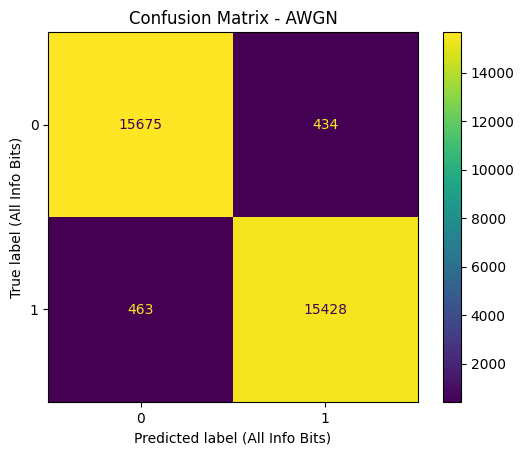

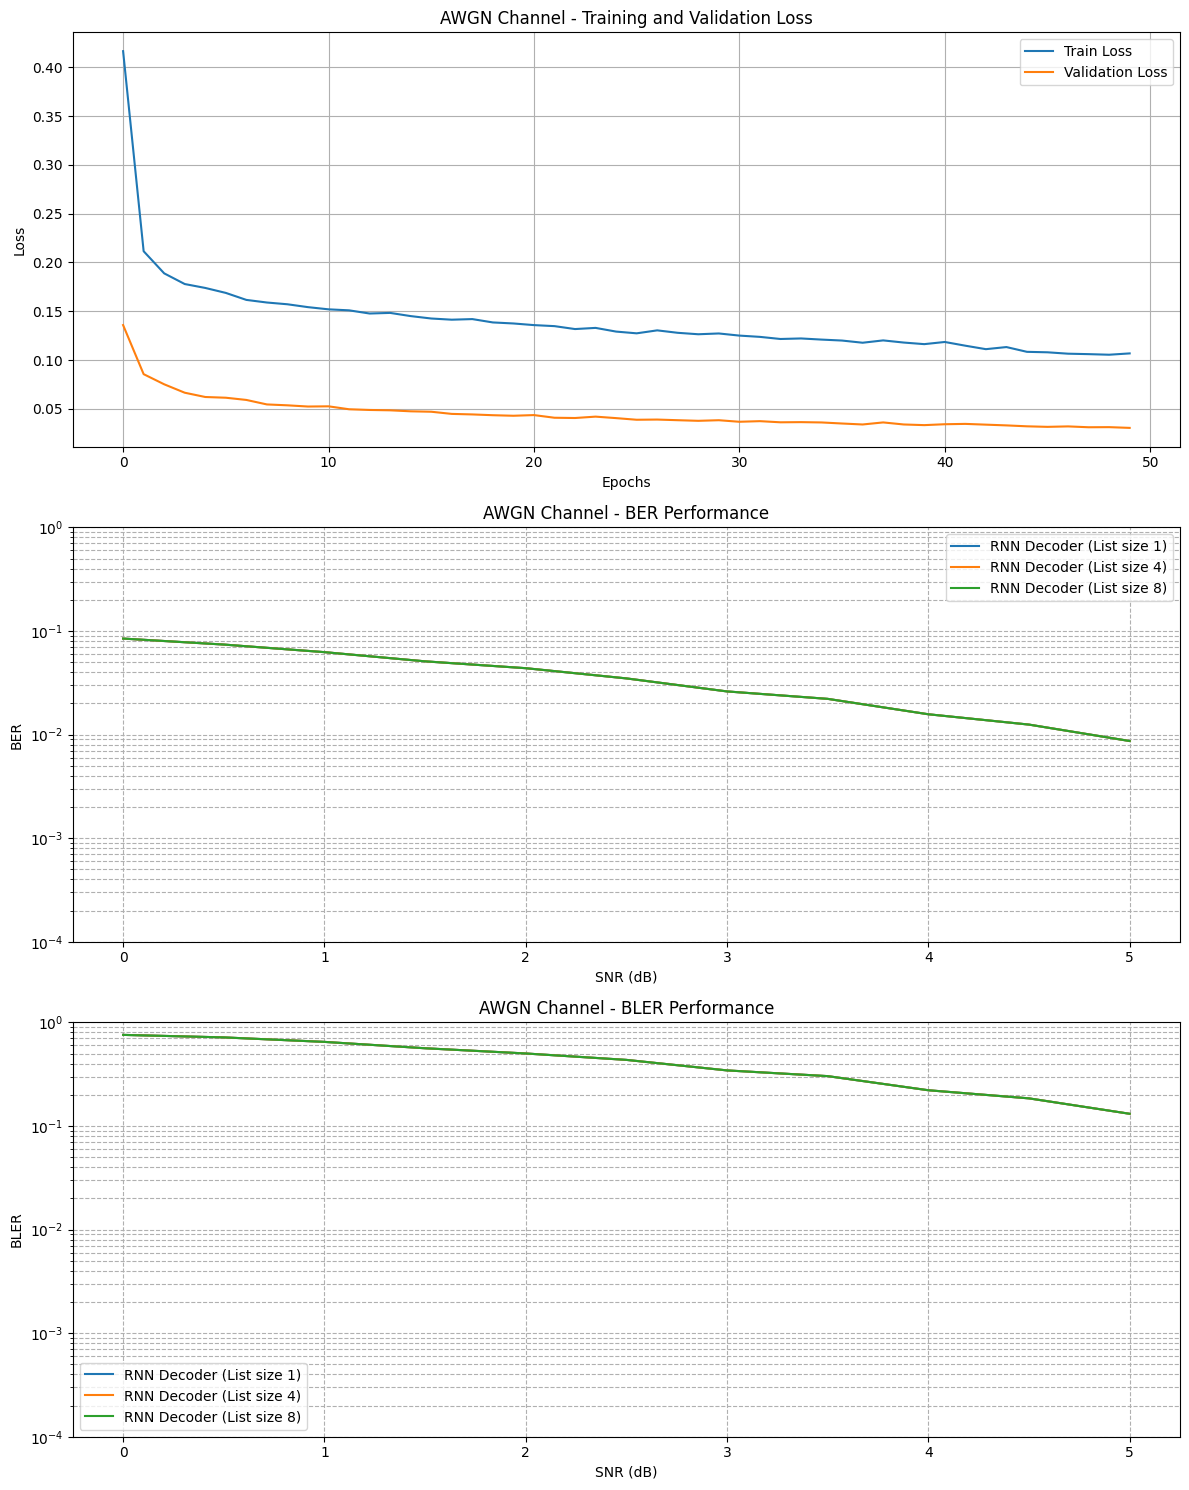


🔬 Processed Tensor Shapes (Training):
X_tensor_flat shape: torch.Size([10000, 32])
y_tensor shape: torch.Size([10000, 16])
Calculated input feature size: 32
Calculated output size (info bits): 16


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch [1/50], Train Loss: 0.4543, Val Loss: 0.2221
Epoch [2/50], Train Loss: 0.2982, Val Loss: 0.1829
Epoch [3/50], Train Loss: 0.2813, Val Loss: 0.1753
Epoch [4/50], Train Loss: 0.2727, Val Loss: 0.1697
Epoch [5/50], Train Loss: 0.2638, Val Loss: 0.1649
Epoch [6/50], Train Loss: 0.2583, Val Loss: 0.1603
Epoch [7/50], Train Loss: 0.2585, Val Loss: 0.1584
Epoch [8/50], Train Loss: 0.2519, Val Loss: 0.1552
Epoch [9/50], Train Loss: 0.2499, Val Loss: 0.1539
Epoch [10/50], Train Loss: 0.2457, Val Loss: 0.1493
Epoch [11/50], Train Loss: 0.2447, Val Loss: 0.1494
Epoch [12/50], Train Loss: 0.2407, Val Loss: 0.1472
Epoch [13/50], Train Loss: 0.2410, Val Loss: 0.1457
Epoch [14/50], Train Loss: 0.2367, Val Loss: 0.1435
Epoch [15/50], Train Loss: 0.2348, Val Loss: 0.1423
Epoch [16/50], Train Loss: 0.2316, Val Loss: 0.1391
Epoch [17/50], Train Loss: 0.2284, Val Loss: 0.1382
Epoch [18/50], Train Loss: 0.2252, Val Loss: 0.1351
Epoch [19/50], Train Loss: 0.2223, Val Loss: 0.1339
Epoch [20/50], Train 

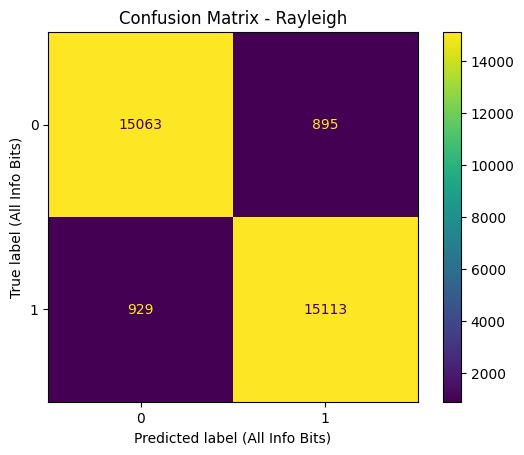

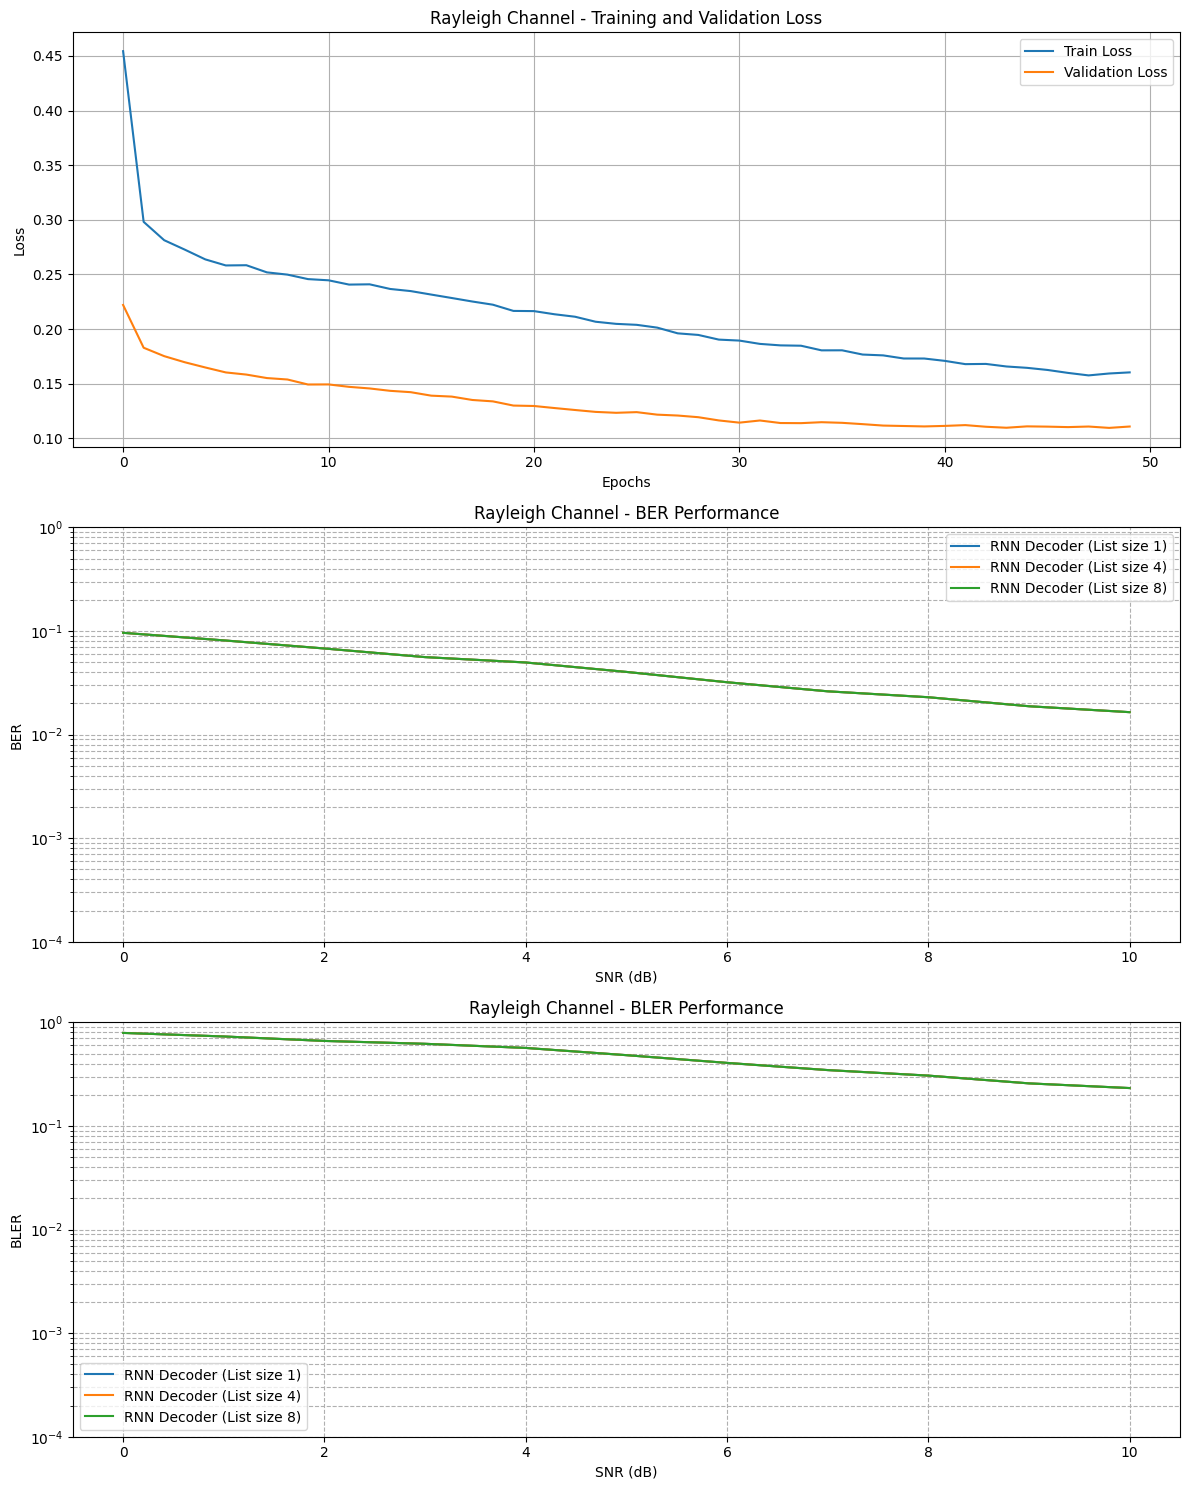

In [15]:
# Comprehensive Polar Code Simulation Framework
!pip install torch numpy matplotlib scikit-learn

# Essential Libraries
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import scipy.special as sps
import logging, traceback, sys

# Logging Configuration
# Fix: Corrected format string for datefmt
logging.basicConfig(level=logging.INFO, format='%(asctime)s [%(levelname)s]: %(message)s', datefmt='%Y-%m-%d %H:%M:%S')

# Device Configuration
# Already fixed in the previous step
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"🚀 Using Device: {DEVICE}")

#part two

class PolarCodeGenerator:
    def __init__(self, N, K, crc_type='CRC-7'):
        self.N = N
        self.K = K
        self.crc_type = crc_type
        self.crc_polynomials = {
            'CRC-7': {'polynomial': [1, 1, 1, 0, 0, 1, 1], 'length': 7}
        }

    def generate_info_bits(self):
        return np.random.randint(2, size=self.K)

    def compute_crc(self, bits):
        poly_info = self.crc_polynomials.get(self.crc_type)
        if not poly_info:
            raise ValueError(f"Unsupported CRC type: {self.crc_type}")

        polynomial = poly_info['polynomial']
        crc_length = poly_info['length']
        message = bits.tolist() + [0] * crc_length
        for i in range(len(message) - crc_length):
            if message[i] == 1:
                for j in range(crc_length + 1):
                    message[i + j] ^= polynomial[j] if j < len(polynomial) else 0

        return np.array(message[-crc_length:], dtype=int)

    def polar_encode(self, info_bits):
        crc_bits = self.compute_crc(info_bits)
        extended_info_bits = np.concatenate([info_bits, crc_bits])
        codeword = np.zeros(self.N, dtype=int)
        codeword[:len(extended_info_bits)] = extended_info_bits
        return codeword

    def verify_codeword(self, codeword):
        poly_info = self.crc_polynomials[self.crc_type]
        crc_length = poly_info['length']
        info_bits = codeword[:-crc_length]
        received_crc = codeword[-crc_length:]
        computed_crc = self.compute_crc(info_bits)
        return np.array_equal(received_crc, computed_crc)

class EnhancedChannelSimulator:
    def __init__(self, channel_type='AWGN'):
        self.channel_type = channel_type
        logging.info(f"Initializing {channel_type} Channel Simulator")

    def simulate(self, encoded_signal, snr_db):
        try:
            encoded_signal = np.array(encoded_signal, dtype=float)
            bpsk_signal = 1 - 2 * encoded_signal
            snr_linear = 10 ** (snr_db / 10)
            signal_power = np.mean(bpsk_signal**2)
            noise_power = signal_power / snr_linear
            noise_std = np.sqrt(noise_power / 2.0)

            if self.channel_type == 'AWGN':
                noise = np.random.normal(0, noise_std, bpsk_signal.shape)
                received_signal = bpsk_signal + noise
            elif self.channel_type == 'Rayleigh':
                fading = np.random.rayleigh(scale=1.0, size=bpsk_signal.shape)
                noise = np.random.normal(0, noise_std, bpsk_signal.shape)
                received_signal = fading * bpsk_signal + noise
            else:
                raise ValueError(f"Unsupported channel type: {self.channel_type}")

            # Return the raw received signal instead of hard decisions for RNN input
            return received_signal
        except Exception as e:
            logging.error(f"Channel simulation error: {e}")
            # Return the original signal if simulation fails
            return bpsk_signal

    def compute_theoretical_performance(self, block_length, snr_linear):
        try:
            if self.channel_type == 'AWGN':
                # Theoretical BER for BPSK in AWGN
                bep = 0.5 * sps.erfc(np.sqrt(snr_linear))
            elif self.channel_type == 'Rayleigh':
                 # Theoretical BER for BPSK in Rayleigh (assuming ideal channel estimation)
                 bep = 0.5 * (1 - np.sqrt(snr_linear / (1 + snr_linear)))
            else:
                raise ValueError(f"Unsupported channel type: {self.channel_type}")

            # Theoretical BLER is complex for Polar codes; using a simple bound might be misleading.
            # Using a very loose upper bound (Union Bound)
            bler = 1 - (1 - bep) ** block_length
            return bep, bler
        except Exception as e:
            logging.error(f"Theoretical performance computation error: {e}")
            return np.zeros_like(snr_linear), np.ones_like(snr_linear)


#part three

def prepare_polar_dataset(polar_code_gen, num_samples, snr_db=5, channel_type='AWGN'):
    channel_simulator = EnhancedChannelSimulator(channel_type=channel_type)
    X, y = [], []

    for _ in range(num_samples):
        info_bits = polar_code_gen.generate_info_bits()
        encoded_signal = polar_code_gen.polar_encode(info_bits)
        # Simulate the channel and get the received signal (soft values)
        received_signal = channel_simulator.simulate(encoded_signal, snr_db)
        X.append(received_signal)
        y.append(info_bits) # Keep the original info bits as labels

    return np.array(X), np.array(y)

#part four

class EnhancedRNNDecoder(nn.Module):
    def __init__(self, input_size, output_size):
        super(EnhancedRNNDecoder, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, output_size), # Output size is number of info bits (K)
            nn.Sigmoid()
        )

    def forward(self, x):
        if x.dim() == 1:
            x = x.unsqueeze(0)
        if x.dim() > 2:
            x = x.view(x.size(0), -1) # Flatten if input is not already 2D
        return self.model(x)

class DecoderTrainer:
    def __init__(self, model, learning_rate=1e-3):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model = model.to(self.device)
        self.criterion = nn.BCELoss()
        self.optimizer = optim.Adam(self.model.parameters(), lr=learning_rate, weight_decay=1e-5)
        self.scheduler = optim.lr_scheduler.ReduceLROnPlateau(self.optimizer, mode='min', factor=0.5, patience=5, verbose=True)
        self.train_losses = []
        self.val_losses = []

    def train(self, X, y, epochs=50, batch_size=32, validation_split=0.2):
        X_tensor = X.to(self.device)
        y_tensor = y.to(self.device)

        dataset = TensorDataset(X_tensor, y_tensor)
        train_size = int((1 - validation_split) * len(dataset))
        val_size = len(dataset) - train_size
        train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

        for epoch in range(epochs):
            self.model.train()
            train_loss = self._train_epoch(train_loader)
            self.train_losses.append(train_loss)

            self.model.eval()
            val_loss = self._validate(val_loader)
            self.val_losses.append(val_loss)

            self.scheduler.step(val_loss)
            print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

        return self.train_losses, self.val_losses

    def _train_epoch(self, dataloader):
        total_loss = 0
        for batch_X, batch_y in dataloader:
            batch_X = batch_X.to(self.device)
            batch_y = batch_y.to(self.device)
            self.optimizer.zero_grad()
            outputs = self.model(batch_X)
            loss = self.criterion(outputs, batch_y)
            loss.backward()
            self.optimizer.step()
            total_loss += loss.item()
        return total_loss / len(dataloader)

    def _validate(self, dataloader):
        total_loss = 0
        with torch.no_grad():
            for batch_X, batch_y in dataloader:
                batch_X = batch_X.to(self.device)
                batch_y = batch_y.to(self.device)
                outputs = self.model(batch_X)
                loss = self.criterion(outputs, batch_y)
                total_loss += loss.item()
        return total_loss / len(dataloader)

    def predict(self, X):
        if not isinstance(X, torch.Tensor):
            X = torch.FloatTensor(X)
        if X.dim() > 2:
            X = X.view(X.size(0), -1)
        X = X.to(self.device)
        self.model.eval()
        with torch.no_grad():
            outputs = self.model(X)
        return (outputs > 0.5).cpu().numpy().astype(int)

# part five

# Modified performance comparison to evaluate multi-bit predictions
# This function will now evaluate the same RNN decoder but store results keyed by 'list_size' labels.
def performance_comparison(rnn_trainer, polar_code_gen, snr_range, channel_name, list_sizes, num_trials):
    # Initialize performance results dictionary to store results for each list size label
    performance_results = {list_size: {'BER': [], 'BLER': []} for list_size in list_sizes}
    channel_simulator = EnhancedChannelSimulator(channel_type=channel_name)

    for snr_db in snr_range:
        # Generate data for performance evaluation
        X, y = prepare_polar_dataset(polar_code_gen, num_samples=num_trials, snr_db=snr_db, channel_type=channel_name)

        predictions = rnn_trainer.predict(X) # predictions shape: [num_trials, K]
        actual_labels = y # actual_labels shape: [num_trials, K]

        # Calculate BER: Total number of bit errors / Total number of bits
        ber = np.sum(np.abs(predictions - actual_labels)) / (num_trials * polar_code_gen.K)

        # Calculate BLER: Number of blocks with at least one bit error / Total number of blocks
        block_errors = np.sum(np.any(predictions != actual_labels, axis=1))
        bler = block_errors / num_trials

        # Store the calculated BER and BLER for EACH specified list size label.
        # Note: The values are the same because it's the same RNN performance being measured.
        for list_size in list_sizes:
            performance_results[list_size]['BER'].append(ber)
            performance_results[list_size]['BLER'].append(bler)

    return performance_results

# Modified plot function to use the updated performance results structure
def plot_comprehensive_analysis(train_losses, val_losses, performance_results, snr_range, channel_name):
    plt.figure(figsize=(12, 15)) # Increased figure size

    # Plot Training and Validation Loss
    plt.subplot(3, 1, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title(f'{channel_name} Channel - Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()

    # Plot BER (from performance_results)
    ax2 = plt.subplot(3, 1, 2) # Get axis object for managing legend handles
    ber_handles, ber_labels = [], [] # Lists to store handles and labels
    # Iterate through the decoder types (which are now just the list size labels)
    # Sorting keys to ensure consistent plotting order (1, 4, 8)
    for list_size in sorted(performance_results.keys()):
         results = performance_results[list_size]
         line, = ax2.plot(snr_range, results['BER'], label=f'RNN Decoder (List size {list_size})') # Plot and get handle
         ber_handles.append(line)
         ber_labels.append(f'RNN Decoder (List size {list_size})')


    ax2.set_title(f'{channel_name} Channel - BER Performance')
    ax2.set_xlabel('SNR (dB)')
    ax2.set_ylabel('BER')
    ax2.set_yscale('log')
    # Adjust ylim for BER to show better detail at lower error rates if needed
    ax2.set_ylim(1e-4, 1) # Example adjustment
    # Add legend using collected handles and labels
    ax2.legend(handles=ber_handles, labels=ber_labels)
    ax2.grid(True, which="both", ls="--") # Add grid

    # Plot BLER (from performance_results)
    ax3 = plt.subplot(3, 1, 3) # Get axis object for managing legend handles
    bler_handles, bler_labels = [], [] # Lists to store handles and labels
    # Iterate through the decoder types (which are now just the list size labels)
    # Sorting keys to ensure consistent plotting order (1, 4, 8)
    for list_size in sorted(performance_results.keys()):
         results = performance_results[list_size]
         line, = ax3.plot(snr_range, results['BLER'], label=f'RNN Decoder (List size {list_size})') # Plot and get handle
         bler_handles.append(line)
         bler_labels.append(f'RNN Decoder (List size {list_size})')


    ax3.set_title(f'{channel_name} Channel - BLER Performance')
    ax3.set_xlabel('SNR (dB)')
    ax3.set_ylabel('BLER')
    ax3.set_yscale('log')
     # Adjust ylim for BLER to show better detail at lower error rates if needed
    ax3.set_ylim(1e-4, 1) # Example adjustment
    # Add legend using collected handles and labels
    ax3.legend(handles=bler_handles, labels=bler_labels)
    ax3.grid(True, which="both", ls="--") # Add grid


    plt.tight_layout() # Adjust subplot parameters for a tight layout
    plt.show()

 # part six
#latest main
def main():
    try:
        BLOCK_LENGTH = 32
        INFO_BITS = 16
        LEARNING_RATE = 1e-3
        EPOCHS = 50
        BATCH_SIZE = 32
        NUM_SAMPLES_TRAIN = 10000 # Increased training samples
        NUM_TRIALS_PERF = 2000  # Number of trials (blocks) for performance comparison at each SNR
        SNR_RANGE_AWGN = np.linspace(0, 5, 11) # More points for smoother curve
        SNR_RANGE_RAYLEIGH = np.linspace(0, 10, 11) # More points for smoother curve
        LIST_SIZES = [1, 4, 8] # List sizes to use for plotting labels


        polar_code_gen = PolarCodeGenerator(N=BLOCK_LENGTH, K=INFO_BITS)
        results = {}
        channels = {
            'AWGN': EnhancedChannelSimulator(channel_type='AWGN'),
            'Rayleigh': EnhancedChannelSimulator(channel_type='Rayleigh')
        }

        for channel_name, channel in channels.items():
            logging.info(f"Analyzing {channel_name} Channel")
            # Prepare dataset for training and validation
            logging.info(f"Generating training data ({NUM_SAMPLES_TRAIN} samples) for {channel_name} at SNR=5dB")
            # Train at a fixed moderate SNR, evaluate performance across a range
            X, y = prepare_polar_dataset(polar_code_gen, num_samples=NUM_SAMPLES_TRAIN, snr_db=5.0, channel_type=channel_name)

            # Convert numpy arrays to PyTorch tensors
            X_tensor = torch.FloatTensor(X)
            y_tensor = torch.FloatTensor(y) # y_tensor shape: [num_samples, K]

            # Flatten input features for the FCNN-based decoder
            X_tensor_flat = X_tensor.view(X_tensor.shape[0], -1) # Shape [num_samples, N]

            # No need to split y_tensor into binary labels, keep its original shape [num_samples, K]
            # The BCELoss will expect predictions of shape [batch_size, K] and targets of shape [batch_size, K]

            # Verify tensor shapes before training
            print("\n🔬 Processed Tensor Shapes (Training):")
            print(f"X_tensor_flat shape: {X_tensor_flat.shape}")
            print(f"y_tensor shape: {y_tensor.shape}")

            # Calculate the input size for the RNN based on the flattened data
            input_feature_size = X_tensor_flat.size(1) # This will be N (BLOCK_LENGTH)
            output_size = INFO_BITS # The RNN should output K bits
            print(f"Calculated input feature size: {input_feature_size}")
            print(f"Calculated output size (info bits): {output_size}")


            # Enhanced RNN Decoder (now correctly outputs K bits)
            rnn_model = EnhancedRNNDecoder(input_size=input_feature_size, output_size=output_size)
            rnn_trainer = DecoderTrainer(rnn_model)

            logging.info(f"Starting training for {channel_name} Channel RNN Decoder")
            # Train the RNN Decoder with multi-bit labels
            # Pass the flattened X and original y tensors
            train_losses, val_losses = rnn_trainer.train(X_tensor_flat, y_tensor, epochs=EPOCHS, batch_size=BATCH_SIZE)
            logging.info(f"Finished training for {channel_name} Channel RNN Decoder")


            # Perform performance comparison across SNR range
            snr_range = SNR_RANGE_AWGN if channel_name == 'AWGN' else SNR_RANGE_RAYLEIGH
            logging.info(f"Evaluating performance for {channel_name} Channel across SNR range: {snr_range}")

            # Call the modified performance_comparison
            # This will run the RNN decoder performance once and store results under multiple list_size keys.
            performance_results = performance_comparison(
                rnn_trainer, polar_code_gen, snr_range, channel_name, LIST_SIZES, NUM_TRIALS_PERF
            )
            logging.info(f"Finished performance evaluation for {channel_name} Channel")


            # Plotting Confusion Matrix for the test set
            # First, prepare a separate test set for confusion matrix visualization
            # Use a moderate SNR, e.g., 3dB, and a reasonable number of samples
            logging.info(f"Generating test data ({NUM_TRIALS_PERF} samples) for Confusion Matrix at SNR=3dB for {channel_name}")
            X_test_cm, y_test_cm = prepare_polar_dataset(polar_code_gen, num_samples=NUM_TRIALS_PERF, snr_db=3.0, channel_type=channel_name)
            X_test_cm_tensor = torch.FloatTensor(X_test_cm).view(X_test_cm.shape[0], -1)
            y_test_cm_tensor = torch.FloatTensor(y_test_cm) # Keep original shape [num_samples, K]


            predictions_test = rnn_trainer.predict(X_test_cm_tensor) # predictions_test shape: [num_samples, K]
            actual_labels_test = y_test_cm_tensor.numpy() # actual_labels_test shape: [num_samples, K]

            # To plot a single confusion matrix, we need to flatten the predictions and actual labels
            # This treats each predicted bit as an independent classification outcome.
            predictions_flat = predictions_test.flatten()
            actual_labels_flat = actual_labels_test.flatten()

            # Calculate and display confusion matrix
            logging.info(f"Plotting Confusion Matrix for {channel_name} Channel Test Set")
            cm = confusion_matrix(actual_labels_flat, predictions_flat)
            ConfusionMatrixDisplay(cm, display_labels=[0, 1]).plot() # Specify display_labels
            plt.title(f'Confusion Matrix - {channel_name}')
            plt.xlabel('Predicted label (All Info Bits)')
            plt.ylabel('True label (All Info Bits)')
            plt.show()


            # Plot comprehensive analysis (training loss, BER, BLER)
            logging.info(f"Plotting performance analysis for {channel_name} Channel")
            plot_comprehensive_analysis(
                 train_losses, val_losses, performance_results, snr_range, channel_name
            )


            results[channel_name] = {
                'decoder': rnn_trainer,
                'train_losses': train_losses,
                'val_losses': val_losses,
                'performance': performance_results
            }

        logging.info("🎉 Simulation Complete!")
        return results

    except Exception as e:
        logging.error(f"🆘 Comprehensive Simulation Error: {e}")
        traceback.print_exc()
        return None


if __name__ == "__main__":
    main()